C:\Users\joems\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
Number of entries in CSV file: 50
Number of samples in image dataset: 2665
Training autoencoder...
Epoch [1/70], Train Loss: 0.0516
Epoch [3/70], Train Loss: 0.0320
Epoch [5/70], Train Loss: 0.0234
Epoch [7/70], Train Loss: 0.0206
Epoch [9/70], Train Loss: 0.0190
Epoch [11/70], Train Loss: 0.0171
Epoch [13/70], Train Loss: 0.0165
Epoch [15/70], Train Loss: 0.0154
Epoch [17/70], Train Loss: 0.0136
Epoch [19/70], Train Loss: 0.0122
Epoch [21/70], Train Loss: 0.0118
Epoch [23/70], Train Loss: 0.0110
Epoch [25/70], Train Loss: 0.0104
Epoch [27/70], Train Loss: 0.0100
Epoch [29/70], Train Loss: 0.0097
Epoch [31/70], Train Loss: 0.0098
Epoch [33/70], Train Loss: 0.0090
Epoch [35/70], Train Loss: 0.0089
Epoch [37/70], Train Loss: 0.0086
Epoch [39/70], Train Loss: 0.0084
Epoch [41/70], Train Loss: 0.0086
Epoch [43/70], Train Loss: 0.0081
Epoch [45/70], Train Loss: 0.0080
Epoch [47/70], Train Loss: 0.0079
Epoch [49/70], Train Loss: 0.0077
Epoch [51/70], Train Loss: 0.0075
Epo

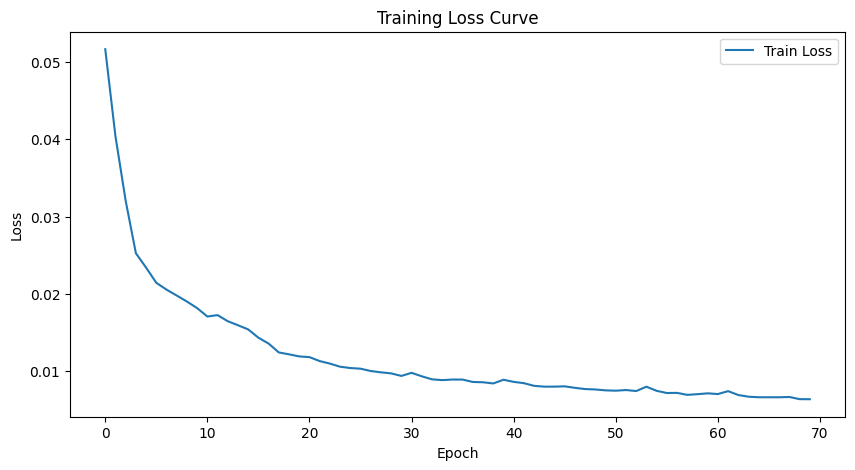

Visualizing reconstructions...


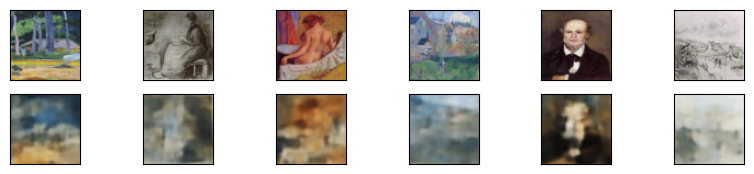

Dataset Classes and Corresponding DataFrame Indices:
Edgar Degas: 3
Pablo Picasso: 1
Paul Gauguin: 4
Pierre-Auguste Renoir: 2
Vincent van Gogh: 0
Dataset Classes and Corresponding DataFrame Indices:
Edgar Degas: 3
Pablo Picasso: 1
Paul Gauguin: 4
Pierre-Auguste Renoir: 2
Vincent van Gogh: 0

K-means Accuracy: 0.2064




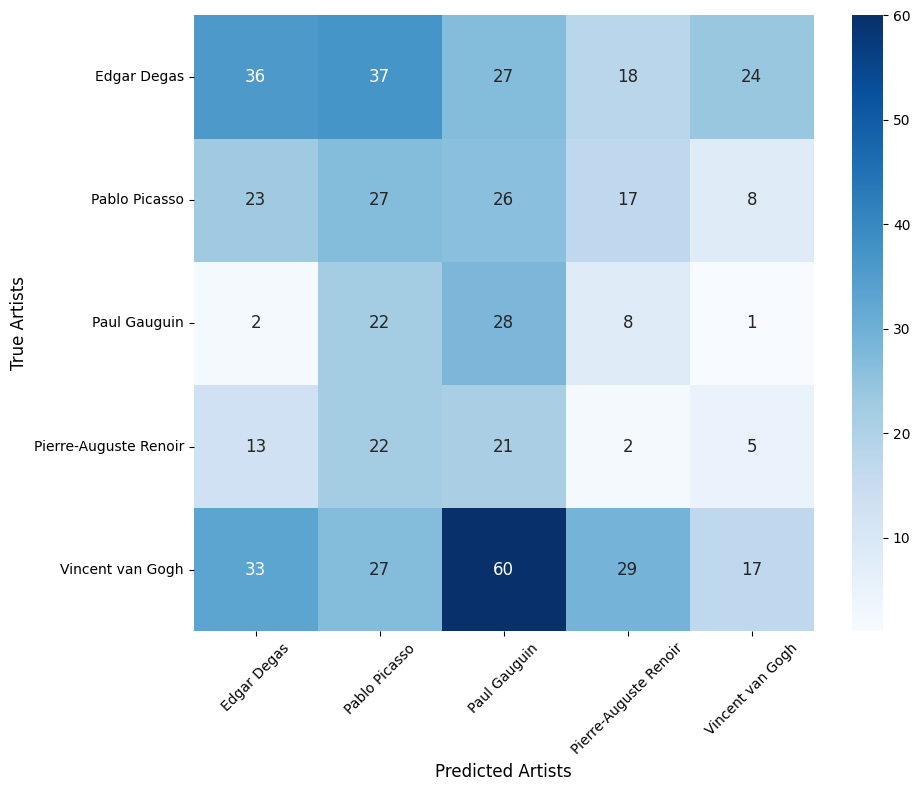



UMAP Feature Extraction part...


C:\Users\joems\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


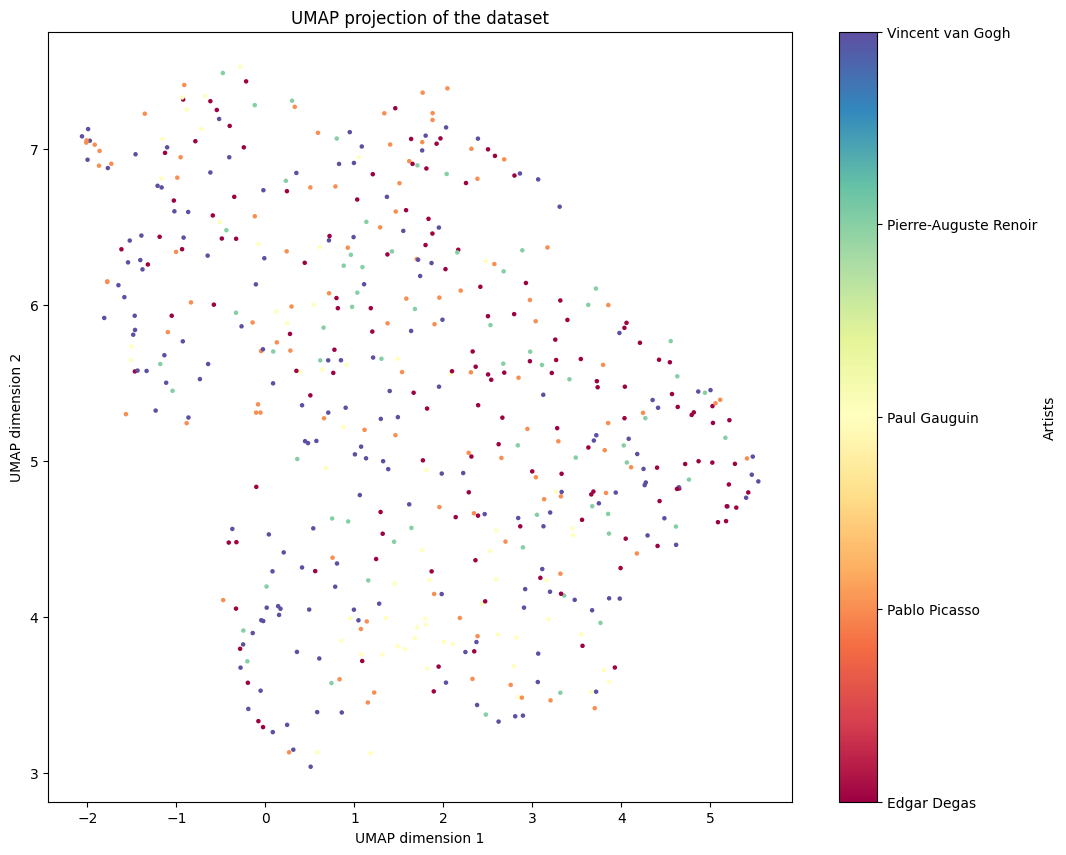



UMAP Feature Extraction End...


GMM Accuracy: 0.2111




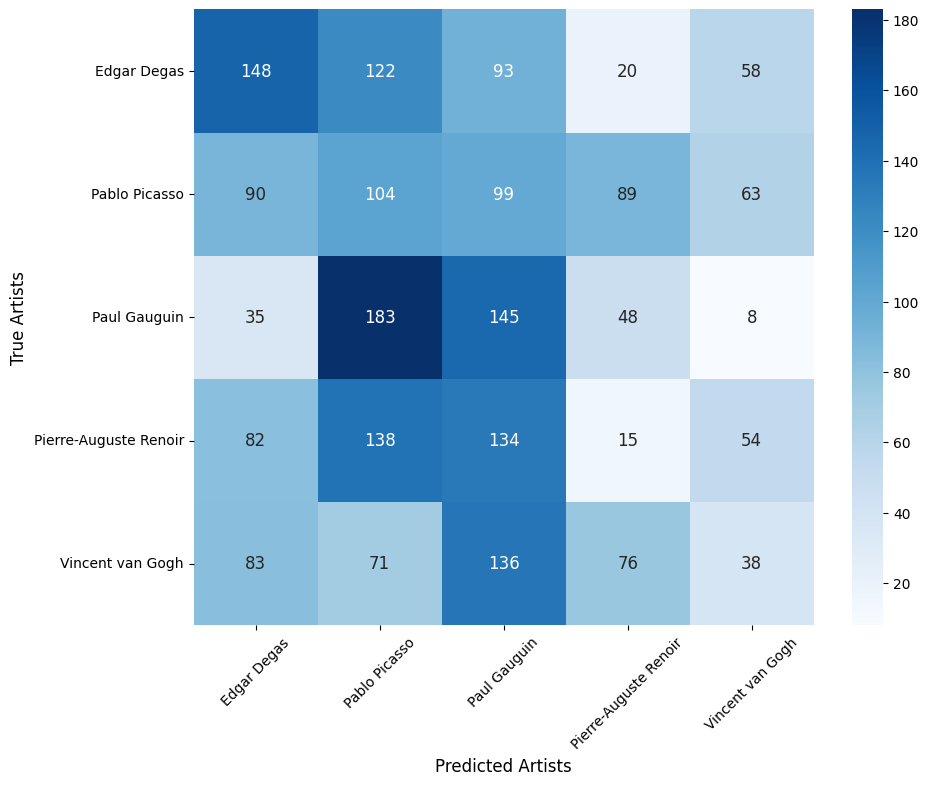



UMAP DBSCAN part...


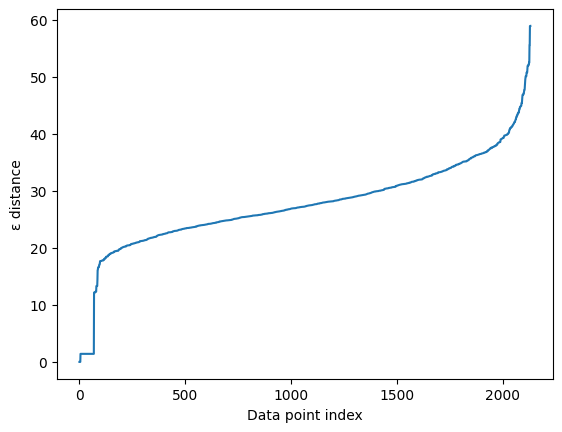

Suggested eps value: 1.414213562400588
The suggested epsilon is: 1.414213562400588


U hierarchical_model part...
Confusion Matrix (Hierarchical) Accuracy: 0.1947



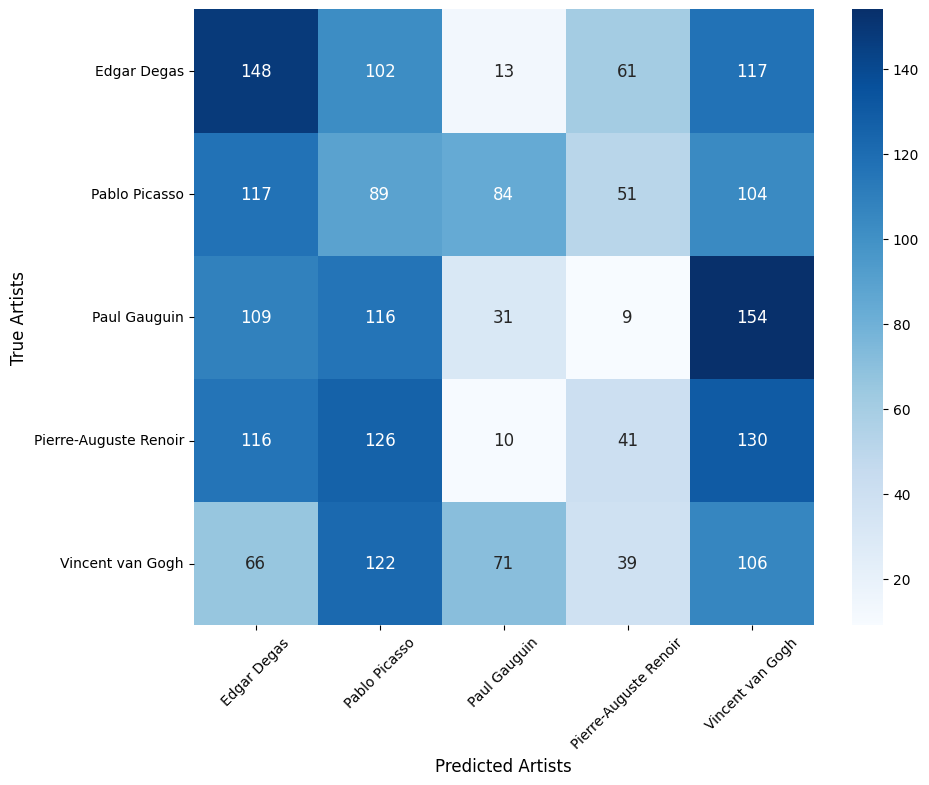

For n_clusters = 2, the average silhouette_score is : 0.22621008999949663
For n_clusters = 3, the average silhouette_score is : 0.07539627134716248
For n_clusters = 4, the average silhouette_score is : 0.0354292288183218
For n_clusters = 5, the average silhouette_score is : 0.021961959895591562
For n_clusters = 6, the average silhouette_score is : 0.01801810717804961
For n_clusters = 7, the average silhouette_score is : 0.021037719576669677
For n_clusters = 8, the average silhouette_score is : 0.02354631705456519
For n_clusters = 9, the average silhouette_score is : 0.027123898304340022
For n_clusters = 10, the average silhouette_score is : 0.006385019579410377


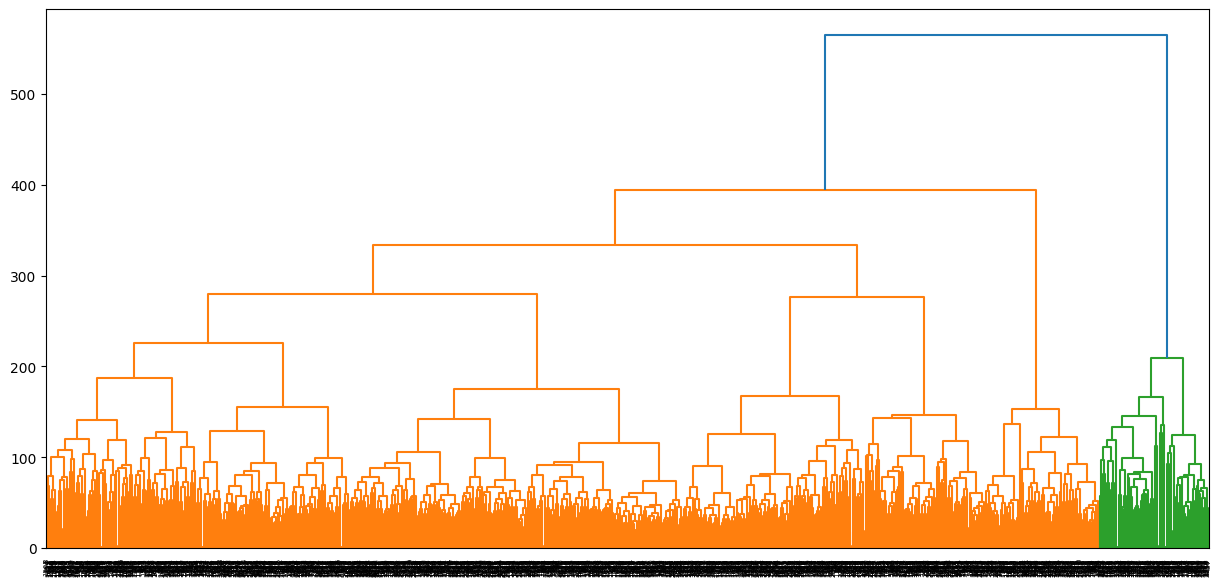

In [1]:


""" 
GMM INTRODUCED + ATTEMPTING SAMPLERS.
"""


""" //One-hot encode the specified column of the DataFrame. // 

:param df: pandas DataFrame containing the data
:param column_name: the name of the column to one-hot encode
:return: a DataFrame with one-hot encoded column and the encoder
"""


""" --- v1.1 change.
    # Create a mapping from class names to indices in the CSV file.
    # Use this mapping to fetch the correct genre for each image in the dataset.
            
    def load_and_encode_genres(excel_path, dataset, indices, column_name='genre'):
        df = pd.read_csv(excel_path)                  # Load your data into a DataFrame
        class_to_index = {row['name']: i for i, row in df.iterrows()}          # Create a mapping from class names to indices in the CSV file
    
        genres = []
           for idx in indices:                                     # Iterate over the indices and fetch the corresponding genre from the CSV file
            class_name = dataset.classes[dataset[idx][1]]            # Get the class name for the current image
            csv_index = class_to_index[class_name]                 # Get the corresponding index in the CSV file
            genre = df.loc[csv_index, column_name]                 # Fetch the genre
            genres.append(genre)
    
        genres = np.array(genres).reshape(-1, 1)                  # Convert genres list to a numpy array and reshape for encoding   
        encoder = OneHotEncoder()                              # Initialize OneHotEncoder // sparse=False
        genre_encoded = encoder.fit_transform(genres)              # Fit and transform the 'genre' column
        genre_encoded = genre_encoded.toarray()                   # Convert the sparse matrix to a dense array
        feature_names = encoder.get_feature_names_out([column_name])        # Get the feature names from encoder
    
        return genre_encoded, feature_names
"""


""" 
    ------------------------- ---------- v1. changes before 11Apr 7pm. Parameterizing.
    class CAE_3_16_WithLatent(nn.Module):
        def __init__(self):
            super(CAE_3_16_WithLatent, self).__init__()   
            
            self.encoder = nn.Sequential(                                       # step1: (n, 3, 64, 64)
                nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),           # (n, 16, 64, 64)
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),                          # (n, 16, 32, 32)
                nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),           # (n, 8, 32, 32)
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)                           # (n, 8, 16, 16)
            )
    
            self.flattened_size = 8 * 16 * 16                                   # j a helpful reference.        
            
            self.latent = nn.Sequential(
                nn.Linear( 8 * 16 * 16, 128 ),                                  # ( 2048 , 128 )     step2: 1st linear. 
                nn.ReLU(),
            )
    
            self.decoder = nn.Sequential(
                nn.Linear( 128, 8 * 16 * 16 ),                                                           # ( 128, 2048 )     step3: 2nd linear. 
                nn.ReLU(),
                nn.Unflatten(1, (8, 16, 16)),                                                            # : (n, 8, 16, 16)  step4: unflattening.
    
                nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1),                         # (n, 16, 32, 32)
                nn.ReLU(),
                nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),                         # (n, 3, 64, 64)
                nn.Sigmoid()
            )
    
             
        def forward(self, x):
            x = self.encoder(x) 
            x = x.view(-1, self.flattened_size)                                # step1: flattening. self.flattened_size = 8 * 16 * 16
            x = self.latent(x)
            x = self.decoder(x)
            return x
    
        def get_latent(self, x):
            x = self.encoder(x)
            x = x.view(-1, self.flattened_size)
            x = self.latent(x)                                                  # ( n, latent_dim, H, W)
            return x

"""



    

# ---------------------------------------------------------------------------------------------------------------------------------------------------------------
# Function for training classifier
def train_classifier(classifier, train_loader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        total_loss = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            # Forward pass
            features = model.get_latent(images).view(images.size(0), -1)
            predictions = classifier(features)
            # Loss and optimize
            loss = criterion(predictions, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        if epoch % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')


# Function to visualize classification results
def visualize_classification_results(classifier, data_loader):
    classifier.eval()  # Set the classifier to evaluation mode
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            features = model.get_latent(images).view(images.size(0), -1)  # Changed
            outputs = classifier(features)
            _, predicted = torch.max(outputs, 1)
            
            # Visualization code here
            plt.figure(figsize=(12, 8))
            for i in range(10):  # Display the first 10 images
                ax = plt.subplot(2, 5, i + 1)
                plt.imshow(images[i].cpu().numpy().transpose(1, 2, 0))
                ax.set_title(f'True: {labels[i].item()}, Pred: {predicted[i].item()}')
                plt.axis('off')
            plt.show()
            break  # Remove this break to visualize more than one batch


def evaluate_classifier(classifier, test_loader, criterion):
    classifier.eval()  # Set the classifier to evaluation mode
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        total_loss = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            features = model.get_latent(images).view(images.size(0), -1)  # Changed
            outputs = classifier(features)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total_loss += criterion(outputs, labels).item()
        avg_loss = total_loss / len(test_loader)
        accuracy = accuracy_score(all_labels, all_predictions)
        conf_matrix = confusion_matrix(all_labels, all_predictions)
    print(f'Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')
    print('Confusion Matrix:')
    print(conf_matrix)
    
    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', ax=ax, cmap='Blues')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_title('Confusion Matrix')
    plt.show()


def random_oversampling(features, labels):
    oversampler = RandomOverSampler(random_state=42)
    features_resampled, labels_resampled = oversampler.fit_resample(features, labels)
    return features_resampled, labels_resampled




    

# ---------------------------------------------------------------------------------------------------------------------------------------------------------------



"""
check the resulting clustering. If DBSCAN is labeling too many points as noise (label -1), consider decreasing eps. 
If it's making too many clusters, consider increasing eps. For min_samples, if the clusters are too sensitive to noise, increase the number, 
and if they are too generalized, decrease the number.
"""


"""
# Load and split dataset v1. -- for all.
def load_dataset(path, transform):
    dataset = ImageFolder(root=path, transform=transform)
    train_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)
    train_dataset = Subset(dataset, train_indices)
    test_dataset = Subset(dataset, test_indices)
    return train_dataset, test_dataset, train_indices, test_indices
"""

import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import random 
import torch
import torchvision
import torch.nn.functional as F
import torch.optim as optim
import multiprocessing as mp
import gc
import seaborn as sns
import torch
import torch.nn.functional as F
import os
import re
from sklearn.metrics import accuracy_score, confusion_matrix
from torch.cuda.amp import GradScaler, autocast
from sklearn.model_selection import train_test_split
from torchvision.datasets import ImageFolder
from time import time
from torchvision import transforms
from torch.utils.data import DataLoader,random_split,Subset,Dataset
from torch import nn
from sklearn.cluster import KMeans
import umap
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import WeightedRandomSampler
from collections import Counter
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN, AgglomerativeClustering





def calculate_dataset_stats(loader):
    mean = 0.0
    var = 0.0
    total_images_count = 0
    for images, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        var += ((images - mean.unsqueeze(1))**2).sum([0, 2])
        total_images_count += batch_samples

    mean /= total_images_count
    var /= total_images_count - 1
    std = torch.sqrt(var)

    return mean, std


def make_sampler(dataset):
    labels = [label for _, label in dataset]     # Get a list of labels from the dataset
    label_counts = Counter(labels)        # Count how often each label occurs
    label_weights = {label: 1.0/count for label, count in label_counts.items()}     # Calculate the inverse of each count to represent the weight    
    weights = [label_weights[label] for label in labels]     # Create a list of weights for each sample in the dataset
    sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)     # Create a sampler with these weights
    return sampler



def load_and_encode_genres(excel_path, dataset, indices, column_name='genre'):
    df = pd.read_csv(excel_path)               # Load your data into a DataFrame
    df = df[df['name'].isin(dataset.classes)]                # Filter DataFrame to only include classes present in the dataset
    df.reset_index(drop=True, inplace=True)                # Reset the index as we may have dropped some rows
    class_to_index = {row['name']: i for i, row in df.iterrows()}            # Create a mapping from class names to indices in the filtered CSV DataFrame
    genres = []             # Initialize an empty list to store genres
    for idx in indices:                # Iterate over the indices and fetch the corresponding genre from the filtered DataFrame
        class_name = dataset.classes[dataset[idx][1]]  # Get the class name for the current image
        csv_index = class_to_index.get(class_name)
        if csv_index is not None:
            genre = df.loc[csv_index, column_name]  # Fetch the genre
            genres.append(genre)
        else:
            raise ValueError(f"Class name '{class_name}' not found in the CSV file.")
    genres = np.array(genres).reshape(-1, 1)                 # Convert genres list to a numpy array and reshape for encoding
    encoder = OneHotEncoder()                            # Initialize OneHotEncoder
    genre_encoded = encoder.fit_transform(genres).toarray()        # Fit and transform the 'genre' column
    feature_names = encoder.get_feature_names_out([column_name])               # Get the feature names from the encoder
    def _print_class_mapping(dataset_classes, class_to_index): # Helper function
        print("Dataset Classes and Corresponding DataFrame Indices:")
        for class_name in dataset_classes:
            index = class_to_index.get(class_name, None)
            print(f"{class_name}: {index}")  
    _print_class_mapping(dataset.classes, class_to_index)   # Call the helper function
    
    return genre_encoded, feature_names



# balance between increasing the width and depth of the network while keeping the model relatively compact to avoid overfitting and capture meaningful features.

#  ONE last chance.. trial on 12th Apr 10PM. god give me one more chanceeee.
class CAE_3_32_WithLatent(nn.Module):
    def __init__(self, latent_dim=256):
        super(CAE_3_32_WithLatent, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1), nn.ReLU(),  # Output shape: (batch_size, 32, 64, 64)
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1), nn.ReLU(),  # Output shape: (batch_size, 32, 64, 64)
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output shape: (batch_size, 32, 32, 32)
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), nn.ReLU(),  # Output shape: (batch_size, 64, 32, 32)
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), nn.ReLU(),  # Output shape: (batch_size, 64, 32, 32)
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output shape: (batch_size, 64, 16, 16)
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), nn.ReLU(),  # Output shape: (batch_size, 128, 16, 16)
            nn.MaxPool2d(kernel_size=2, stride=2)  # Output shape: (batch_size, 128, 8, 8)
        )
        self.flattened_size = 128 * 8 * 8
        self.latent_dim = latent_dim
        self.latent = nn.Sequential(
            nn.Linear(self.flattened_size, self.latent_dim), nn.ReLU(),  # Output shape: (batch_size, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, self.flattened_size), nn.ReLU(),  # Output shape: (batch_size, 128*8*8)
            nn.Unflatten(1, (128, 8, 8)),  # Output shape: (batch_size, 128, 8, 8)
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1), nn.ReLU(),  # Output shape: (batch_size, 64, 16, 16)
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=1, padding=1), nn.ReLU(),  # Output shape: (batch_size, 64, 16, 16)
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1), nn.ReLU(),  # Output shape: (batch_size, 32, 32, 32)
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=1, padding=1), nn.ReLU(),  # Output shape: (batch_size, 32, 32, 32)
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1), nn.Sigmoid()  # Output shape: (batch_size, 3, 64, 64)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(-1, self.flattened_size)
        x = self.latent(x)
        x = self.decoder(x)
        return x

    def get_latent(self, x):
        x = self.encoder(x)
        x = x.view(-1, self.flattened_size)
        x = self.latent(x)
        return x





# class CAE_3_16_WithLatent(nn.Module):
#     def __init__(self, latent_dim=128):  # Add latent_dim as a parameter with a default value
#         super(CAE_3_16_WithLatent, self).__init__()
#         self.encoder = nn.Sequential(
#             nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1), nn.ReLU(), # Output shape: (batch_size, 16, 64, 64)
#             nn.MaxPool2d(kernel_size=2, stride=2),  # Output shape: (batch_size, 16, 32, 32)
#             nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1), nn.ReLU(), # Output shape: (batch_size, 8, 32, 32)
#             nn.MaxPool2d(kernel_size=2, stride=2)  # Output shape: (batch_size, 8, 16, 16)
#         )
#         self.flattened_size = 8 * 16 * 16
#         self.latent_dim = latent_dim  # Use the latent_dim parameter
#         self.latent = nn.Sequential(
#             nn.Linear(self.flattened_size, self.latent_dim), nn.ReLU(), # Output shape: (batch_size, latent_dim)
#              )
#         self.decoder = nn.Sequential(
#             nn.Linear(self.latent_dim, self.flattened_size), nn.ReLU(), # Output shape: (batch_size, 8*16*16)
#             nn.Unflatten(1, (8, 16, 16)),  # Output shape: (batch_size, 8, 16, 16)
#             nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1), nn.ReLU(), # Output shape: (batch_size, 16, 32, 32)
#             nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  nn.Sigmoid()  # Output shape: (batch_size, 3, 64, 64) , # Ensures output values are in the range [0, 1]
#         )

#     def forward(self, x):
#         x = self.encoder(x)  # Encode input
#         x = x.view(-1, self.flattened_size)  # Flatten encoded tensor
#         x = self.latent(x)  # Pass through latent layer
#         x = self.decoder(x)  # Decode to reconstruct input
#         return x

#     def get_latent(self, x):
#         x = self.encoder(x)  # Encode input
#         x = x.view(-1, self.flattened_size)  # Flatten encoded tensor
#         x = self.latent(x)  # Get latent representation
#         return x



class Classifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Classifier, self).__init__()
        self.fc = nn.Linear(input_size, num_classes)
    def forward(self, x):
        return self.fc(x)




# Save model weights
def save_model(model, path):
    torch.save(model.state_dict(), path)

# Load model weights
def load_model(model, path):
    model.load_state_dict(torch.load(path))


# Train the model
def train_autoencoder_with_regularized_loss(model, train_loader, criterion, optimizer, num_epochs, lambda_reg):
    for epoch in range(num_epochs):
        for data in train_loader:
            img, _ = data
            img = img.to(device)
            # Forward pass
            output = model(img)
            # -- changing. loss = criterion(output, img) 
            recon_loss = criterion(output, img)                                      # // changing from casual to regularized loss.
            reg_loss = 0
            for param in model.parameters():
                reg_loss += torch.sum(param.pow(2))
            # Combine losses
            loss = recon_loss + lambda_reg * reg_loss
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if epoch % 2 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Combined Recon Loss: {loss.item():.4f}')


""" v1.1 train_autoencoder with no curves:
def train_autoencoder(model, train_loader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        for data in train_loader:
            img, _ = data
            img = img.to(device)
            
            output = model(img)
            recon_loss = criterion(output, img)
            optimizer.zero_grad()
            recon_loss.backward()
            optimizer.step()
        if epoch % 2 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Recon Loss: {recon_loss.item():.4f}')
"""


def train_autoencoder(model, train_loader, criterion, optimizer, num_epochs):
    train_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        for data in train_loader:
            img, _ = data
            img = img.to(device)
            output = model(img)
            loss = criterion(output, img)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        if epoch % 2 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}')

    # After training completes, plot the training loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training Loss Curve')
    plt.show()
    
    return train_losses


# Testing and visualization
def test_and_visualize(model, test_loader):
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            recon = model(data)
            break  # Only take the first batch for visualization
    plt.figure(figsize=(10, 2))
    num_images = 6
    for i in range(num_images):
        # Display original images
        ax = plt.subplot(2, num_images, i + 1)
        plt.imshow(data[i].cpu().numpy().transpose(1, 2, 0))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        # Display reconstructed images
        ax = plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(recon[i].cpu().numpy().transpose(1, 2, 0))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()


# Function to extract features using the autoencoder's encoder
def extract_features(data_loader, model):
    features = []
    labels = []
    with torch.no_grad():
        for images, targets in data_loader:
            images = images.to(device)
            labels.extend(targets.numpy())
            latent_features = model.get_latent(images).view(images.size(0), -1)
            features.extend(latent_features.cpu().numpy())
    return np.array(features), np.array(labels)


# Function to predict labels using k-means
def predict_kmeans(data_loader, model, kmeans):
    predicted_labels = []
    true_labels = []
    with torch.no_grad():
        for images, targets in data_loader:
            images = images.to(device)
            true_labels.extend(targets.numpy())
            latent_features = model.get_latent(images).view(images.size(0), -1)
            latent_features = latent_features.cpu().numpy()
            cluster_labels = kmeans.predict(latent_features)
            predicted_labels.extend(cluster_labels)
    return np.array(predicted_labels), np.array(true_labels)                 # conv into np array and then send them as return values.




def train_and_evaluate_gmm(features, labels, num_classes):
    gmm = GaussianMixture(n_components=num_classes, random_state=42)
    gmm.fit(features)
    predicted_labels = gmm.predict(features)
    accuracy = accuracy_score(labels, predicted_labels)
    conf_matrix = confusion_matrix(labels, predicted_labels)
    
    return accuracy, conf_matrix, gmm   




# number of nearest neighbors UMAP will consider when constructing the initial high-dimensional graph.
# controls the tightness of UMAP's embedding. 
# With a larger value, points are clumped together more tightly in the low-dimensional representation, potentially obscuring detail.
# parameter specifies the number of dimensions in which to embed the data. For visualization, you usually set it to 2 (or 3 for 3D plots).



def visualize_umap(features, labels, artist_names, n_neighbors=15, min_dist=0.1, n_components=2):
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components, random_state=42)
    embedding = reducer.fit_transform(features)
    
    unique_labels = np.unique(labels)
    unique_artist_names = [artist_names[int(i)] for i in unique_labels]
    
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='Spectral', s=5)
    
    # Create a color bar with artist names
    colorbar = plt.colorbar(scatter, ticks=unique_labels)
    colorbar.set_label('Artists')
    colorbar.set_ticklabels(unique_artist_names)
    
    plt.title('UMAP projection of the dataset')
    plt.xlabel('UMAP dimension 1')
    plt.ylabel('UMAP dimension 2')
    plt.show()



def predict_and_visualize_kmeans(kmeans, data_loader, model, dataset, combined_features):
    true_labels = []
    predicted_labels = []
    with torch.no_grad():
        for images, targets in data_loader:
            images = images.to(device)
            true_labels.extend(targets.numpy())
    predicted_labels = kmeans.predict(combined_features)                                  # Make predictions using KMeans
    accuracy = accuracy_score(true_labels, predicted_labels)
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    print(f'\nK-means Accuracy: {accuracy:.4f}\n\n')

    visualize_conf_matrix(conf_matrix, dataset, title='Confusion Matrix')

    # plt.figure(figsize=(25, 22))    
    # sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
    # plt.xlabel('Predicted Artists')
    # plt.ylabel('True Artists')
    # plt.title('Confusion Matrix')
    # plt.xticks(rotation=90)                                                              # Rotate x-axis labels
    # plt.yticks(rotation=0)
    # plt.show()
    
    return accuracy, conf_matrix



def visualize_gmm_confmatrix(gmm_conf_matrix, gmm_accuracy, dataset):
    print(f"\n\nGMM Accuracy: {gmm_accuracy:.4f}\n\n")
    
    visualize_conf_matrix(gmm_conf_matrix, dataset, title='Confusion Matrix')
    # sns.heatmap(gmm_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
    # plt.xlabel('Predicted Artists')
    # plt.ylabel('True Artists')
    # plt.title('Confusion Matrix (GMM)')
    # plt.xticks(rotation=90)
    # plt.yticks(rotation=0)
    # plt.show()
        

def visualize_conf_matrix(conf_matrix, dataset, title='Confusion Matrix'):
    plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
    ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes, annot_kws={"size": 12})  # Increase annotation size
    plt.xlabel('Predicted Artists', fontsize=12)  # Adjust fontsize as needed
    plt.ylabel('True Artists', fontsize=12)  # Adjust fontsize as needed
    
    plt.xticks(rotation=45, fontsize=10)  # Rotate x-axis labels, adjust fontsize as needed
    plt.yticks(rotation=0, fontsize=10)  # Adjust fontsize as needed
    plt.show()


# DBSCAN doesn't predict new points and doesn't have labels, but we can use fit_predict to get labels for our training set
def train_and_evaluate_dbscan(features, eps, min_samples):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    predicted_labels = dbscan.fit_predict(features)
    # Since DBSCAN doesn't provide labels for all points (noise points get label -1),     # we cannot calculate accuracy as usual. We could assign them manually if needed.
    # Here, we will return the labels and the DBSCAN instance.
    return predicted_labels, dbscan


def visualize_clustering_confmatrix(true_labels, predicted_labels, dataset, title):
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    accuracy = accuracy_score(true_labels, predicted_labels)
    print(f'{title} Accuracy: {accuracy:.4f}\n')
    visualize_conf_matrix(conf_matrix, dataset, title=title)


def train_and_evaluate_hierarchical(features, num_classes):    # Hierarchical clustering
    hierarchical = AgglomerativeClustering(n_clusters=num_classes)
    predicted_labels = hierarchical.fit_predict(features)                     # Hierarchical clustering doesn't have an intrinsic 'predict' phase, it labels all in 'fit'

    return predicted_labels, hierarchical              # Hence, we'll return the labels and the model instance.


from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

def find_elbow_point(distances):
    second_derivative = np.diff(distances, n=2)            # Calculate the second derivative
    elbow_index = np.argmax(second_derivative)                # The 'elbow' point is where the second derivative is maximized
    return distances[elbow_index + 1]  # plus 1 due to the nature of diff reducing the array size


def plot_dbscan_eps(data, min_samples):
    nn = NearestNeighbors(n_neighbors=min_samples).fit(data)
    distances, indices = nn.kneighbors(data)
    sorted_distances = np.sort(distances[:,min_samples-1])
    
    plt.plot(sorted_distances)
    plt.ylabel('ε distance')
    plt.xlabel('Data point index')
    plt.show()

    eps_value = find_elbow_point(sorted_distances)               # Attempt to find the 'elbow' point programmatically
    print(f"Suggested eps value: {eps_value}")
    return eps_value


from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering

def get_silhouette_score(data, range_n_clusters):
    for n_clusters in range_n_clusters:
        clusterer = AgglomerativeClustering(n_clusters=n_clusters)
        cluster_labels = clusterer.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        print(f"For n_clusters = {n_clusters}, the average silhouette_score is : {silhouette_avg}")


from scipy.cluster.hierarchy import dendrogram, linkage

# plot_dendrogram is used to visually assess the possible number of clusters, which complements the silhouette score analysis well.

def plot_dendrogram(data, method='ward'):
    linked = linkage(data, method=method)
    plt.figure(figsize=(15, 7))
    dendrogram(linked,
               orientation='top',
               distance_sort='descending',
               show_leaf_counts=True)
    plt.show()

# -------------------------------------------------------------------------------------------------------------------------------------------------- !!
def load_dataset(path, train_transform, test_transform):
    dataset = ImageFolder(root=path, transform=train_transform)
    train_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)
    train_dataset = Subset(dataset, train_indices)
    test_dataset = Subset(dataset, test_indices)
    test_dataset.dataset.transform = test_transform
    return train_dataset, test_dataset, train_indices, test_indices



# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Main routine
def main():
    
    # Hyperparameters
    num_epochs = 70
    learning_rate = 0.001
    batch_size = 64
    lambda_reg = 0.0001  # Regularization strength --- failing entirely.
    # based on your latent space size
    latent_dim = 256  
    
    # Data paths and transformations
    # og path with all datas.
    # path = r'C:\Users\joems\OneDrive\Desktop\FAI project s1\Best Artworks Of All Times\resized\resized_organized'

    path = r'C:\Users\joems\OneDrive\Desktop\FAI project s1\Best Artworks Of All Times\resized\resized_organized_top5'
    excel_path = r'C:\Users\joems\OneDrive\Desktop\FAI project s1\Best Artworks Of All Times\artists.csv'

    
    # Define transform
    transform = transforms.Compose([ transforms.Resize((64, 64)), transforms.ToTensor() ])

    train_transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=5), # bad. transforms.RandomCrop(64, padding=4),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    
    test_transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    

    # checks --
    df = pd.read_csv(excel_path)
    print(f"Number of entries in CSV file: {len(df)}")
    dataset = ImageFolder(root=path, transform=transform)
    print(f"Number of samples in image dataset: {len(dataset)}")

    # loaders. v1 older. # train_dataset, test_dataset, train_indices, test_indices = load_dataset(path, transform)
    train_dataset, test_dataset, train_indices, test_indices = load_dataset(path, train_transform, test_transform)

    # loaders v2 approach: samplers.
    # train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    # test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # introducing sampler code. only for train dataset.
    train_sampler = make_sampler(train_dataset)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler =train_sampler, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    
    num_classes = len(dataset.classes)           # !! dynamic num classes.
    

    # smaller model, 3 16, quick to train. favorite.
    # model = CAE_3_16_WithLatent(latent_dim=latent_dim).to(device)        # Initialize the model

    # slightly later. experiment time.
    model = CAE_3_32_WithLatent(latent_dim=latent_dim).to(device)        # Initialize the model

    
    criterion = nn.MSELoss()        # Loss and optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    lin_classification_criterion = nn.CrossEntropyLoss()         # Add a classification criterion for the classifier -- we are currently not using this linear classifier.

    # Load autoencoder weights if available. training part.
    if os.path.exists('autoencoder_model_CAE_3_32.ckpt'):
        load_model(model, 'autoencoder_model_CAE_3_32.ckpt')
    else:
        print("Training autoencoder...")
        train_autoencoder(model, train_loader, criterion, optimizer, num_epochs)
        save_model(model, 'autoencoder_model_CAE_3_32.ckpt')

    
    model.eval()

    # Step 9: Visualization
    print("Visualizing reconstructions...")
    test_and_visualize(model, test_loader)

    # Step 4: Feature Extraction  -- are of this shape. [batch_size, latent_dimensions]. 
    train_features, train_labels = extract_features(train_loader, model)
    test_features, test_labels = extract_features(test_loader, model)
    
    # Step 5: Genre Encoding --- flawed approach without mapping   # genre_encoded_train, _ = load_and_encode_genres(excel_path, train_indices)        
    # Step 5: Genre Encoding -- v1.         # genre_encoded_train, _ = load_and_encode_genres(excel_path, train_dataset.dataset, train_indices) # genre_encoded_test, _ = load_and_encode_genres(excel_path, test_dataset.dataset, test_indices)

    genre_encoded_train, feature_names_train = load_and_encode_genres(excel_path, train_dataset.dataset, train_indices)
    genre_encoded_test, feature_names_test = load_and_encode_genres(excel_path, test_dataset.dataset, test_indices)

    # Step 6: Feature Combination
    combined_train_features = np.hstack((train_features, genre_encoded_train))
    combined_test_features = np.hstack((test_features, genre_encoded_test))

    
    # Step 7: Clustering, kmeans initialization
    kmeans = KMeans(n_clusters=num_classes, random_state=42)
    kmeans.fit(combined_train_features)

    # Step 8: Evaluation # previous code: accuracy, conf_matrix = predict_and_visualize_kmeans(kmeans, test_loader, model, test_dataset.dataset)
    accuracy, conf_matrix = predict_and_visualize_kmeans(kmeans, test_loader, model, test_dataset.dataset, combined_test_features)

    # Step 10: UMAP presentation.
    print(f"\n\nUMAP Feature Extraction part...") 
    visualize_umap(combined_test_features, test_labels, test_dataset.dataset.classes)
    print(f"\n\nUMAP Feature Extraction End...")

    # Step 11:
    gmm_accuracy, gmm_conf_matrix, gmm = train_and_evaluate_gmm(combined_train_features, train_labels, num_classes)
    # Step 12: Visualization for GMM
    visualize_gmm_confmatrix(gmm_conf_matrix, gmm_accuracy, test_dataset.dataset)


    print(f"\n\nUMAP DBSCAN part...") 
    # Step 13: DBSCAN and hierarchial clustering - AgglomerativeClustering
    suggested_eps = plot_dbscan_eps(combined_train_features, min_samples=5)                         # Use an appropriate min_samples value    
    print(f"The suggested epsilon is: {suggested_eps}")
    dbscan_labels, dbscan_model = train_and_evaluate_dbscan(combined_train_features, eps=suggested_eps, min_samples=5)

    # DBSCAN confusion matrix doesnt really make any sense.
    # visualize_clustering_confmatrix(train_labels, dbscan_labels, train_dataset.dataset, title='Confusion Matrix (DBSCAN)')

    print(f"\n\nU hierarchical_model part...") 
    hierarchical_labels, hierarchical_model = train_and_evaluate_hierarchical(combined_train_features, num_classes=num_classes)
    visualize_clustering_confmatrix(train_labels, hierarchical_labels, train_dataset.dataset, title='Confusion Matrix (Hierarchical)')
    
    get_silhouette_score(combined_train_features, range(2, 11))                       # Check silhouette score for different numbers of clusters
    plot_dendrogram(combined_train_features)                                          # Plot dendrogram for your dataset




if __name__ == '__main__':
    main()


Using device: cuda
Number of entries in CSV file: 50
Number of samples in image dataset: 2665
Training autoencoder...
Epoch [1/70], Train Loss: 0.0493
Epoch [3/70], Train Loss: 0.0282
Epoch [5/70], Train Loss: 0.0257
Epoch [7/70], Train Loss: 0.0238
Epoch [9/70], Train Loss: 0.0232
Epoch [11/70], Train Loss: 0.0203
Epoch [13/70], Train Loss: 0.0184
Epoch [15/70], Train Loss: 0.0178
Epoch [17/70], Train Loss: 0.0173
Epoch [19/70], Train Loss: 0.0169
Epoch [21/70], Train Loss: 0.0164
Epoch [23/70], Train Loss: 0.0159
Epoch [25/70], Train Loss: 0.0157
Epoch [27/70], Train Loss: 0.0150
Epoch [29/70], Train Loss: 0.0149
Epoch [31/70], Train Loss: 0.0148
Epoch [33/70], Train Loss: 0.0142
Epoch [35/70], Train Loss: 0.0141
Epoch [37/70], Train Loss: 0.0139
Epoch [39/70], Train Loss: 0.0132
Epoch [41/70], Train Loss: 0.0135
Epoch [43/70], Train Loss: 0.0127
Epoch [45/70], Train Loss: 0.0128
Epoch [47/70], Train Loss: 0.0125
Epoch [49/70], Train Loss: 0.0123
Epoch [51/70], Train Loss: 0.0123
Epo

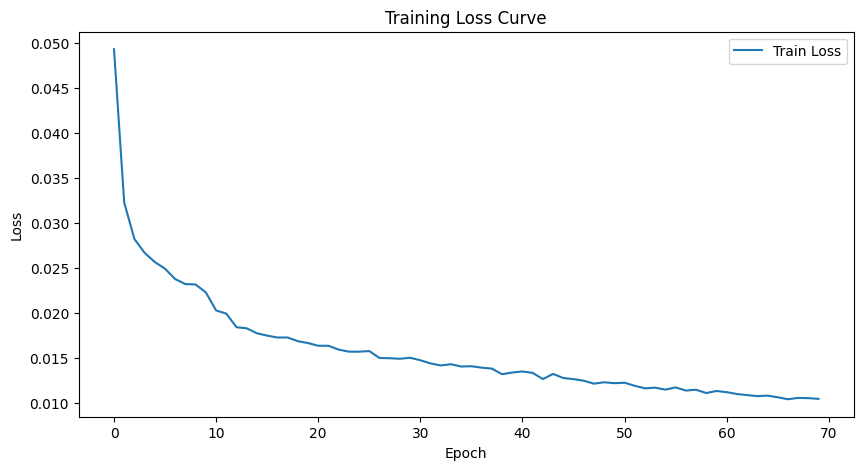

Visualizing reconstructions...


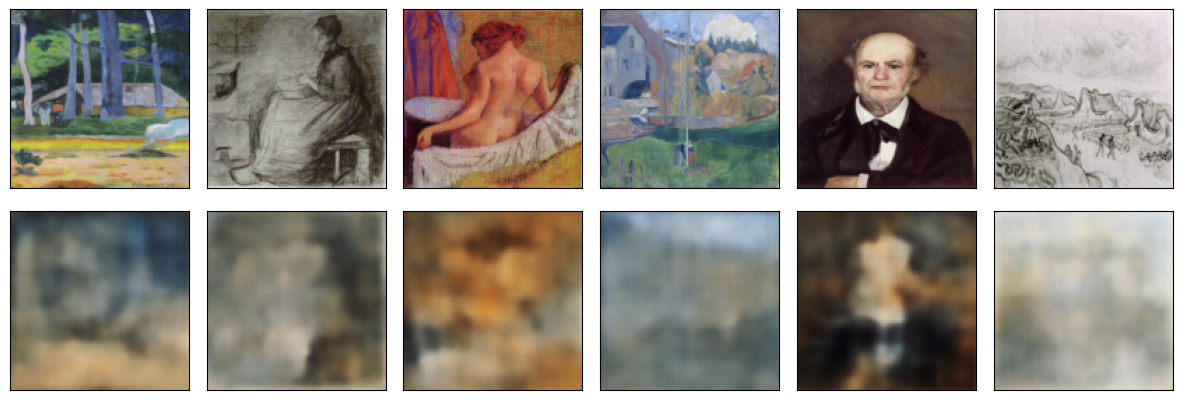

Dataset Classes and Corresponding DataFrame Indices:
Edgar Degas: 3
Pablo Picasso: 1
Paul Gauguin: 4
Pierre-Auguste Renoir: 2
Vincent van Gogh: 0
Dataset Classes and Corresponding DataFrame Indices:
Edgar Degas: 3
Pablo Picasso: 1
Paul Gauguin: 4
Pierre-Auguste Renoir: 2
Vincent van Gogh: 0

K-means Accuracy: 0.3152




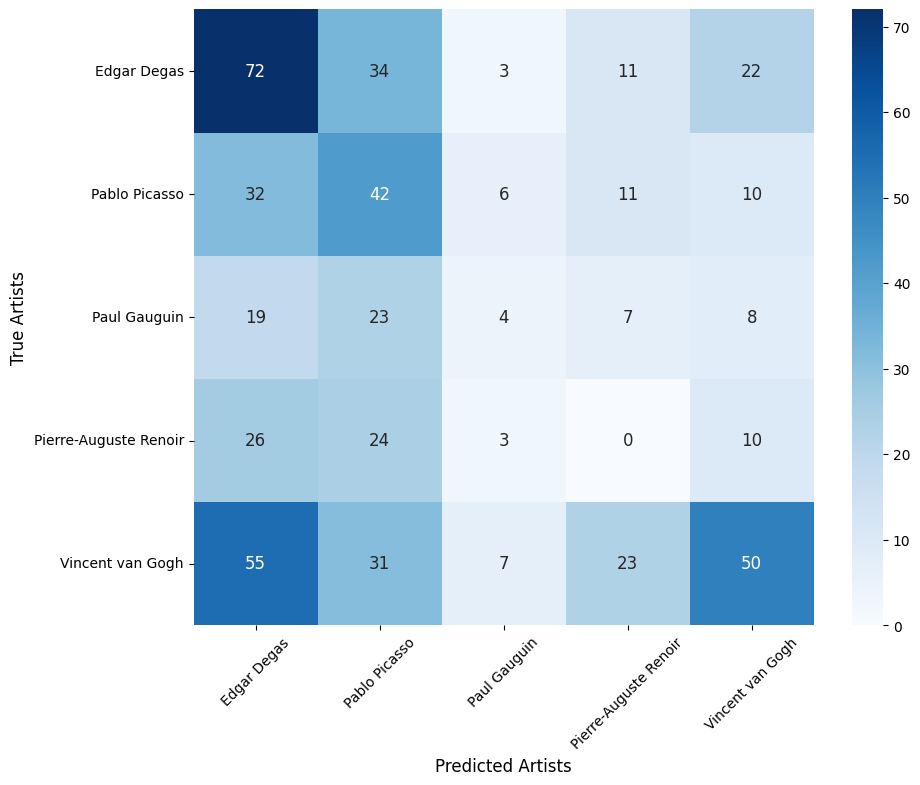



UMAP Feature Extraction part...


C:\Users\joems\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


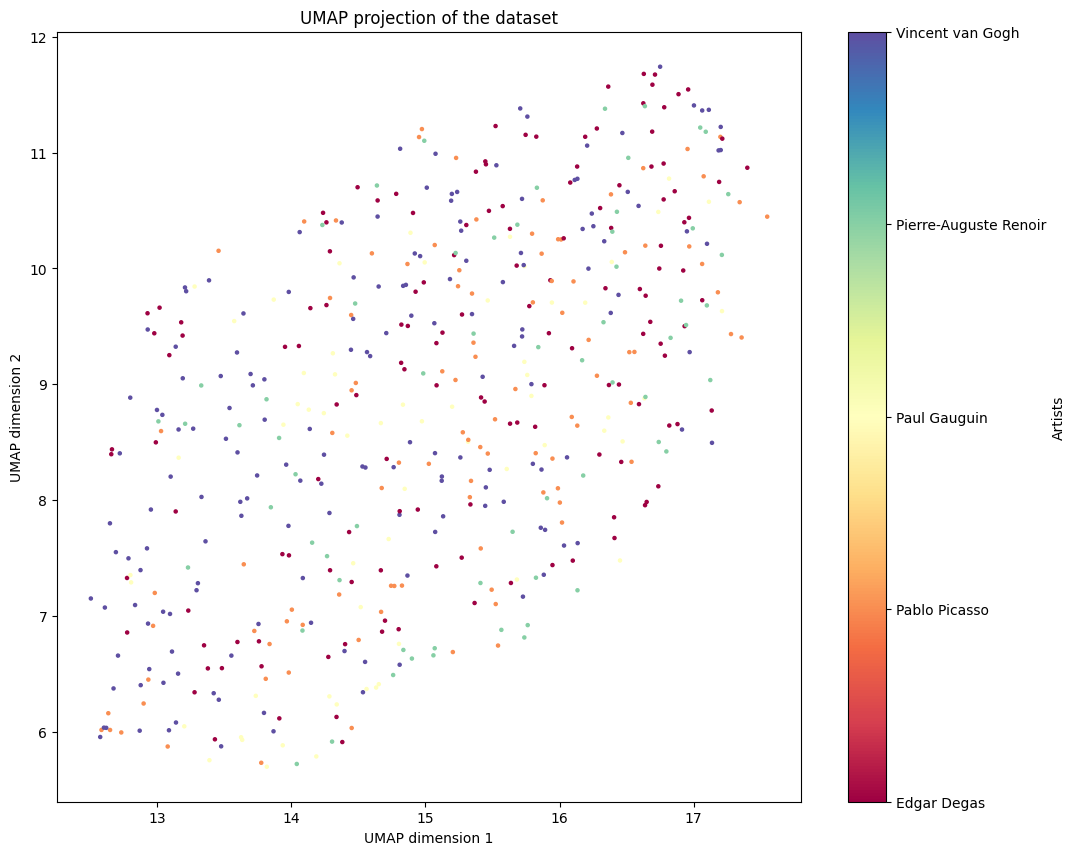



UMAP Feature Extraction End...


GMM Accuracy: 0.2294




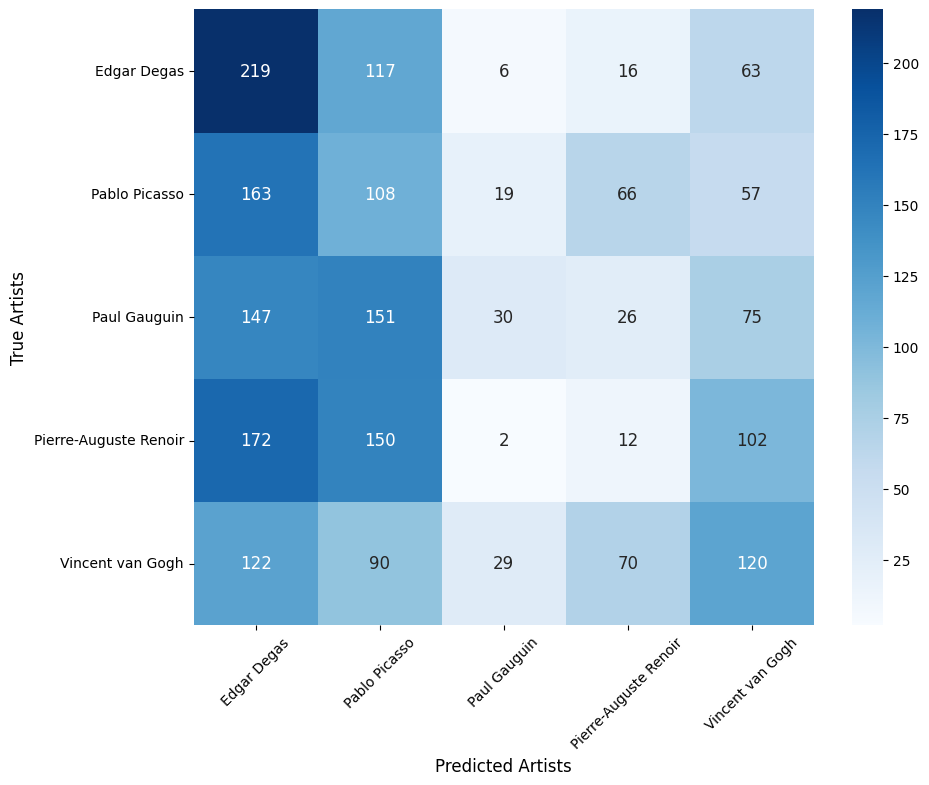



UMAP DBSCAN part...


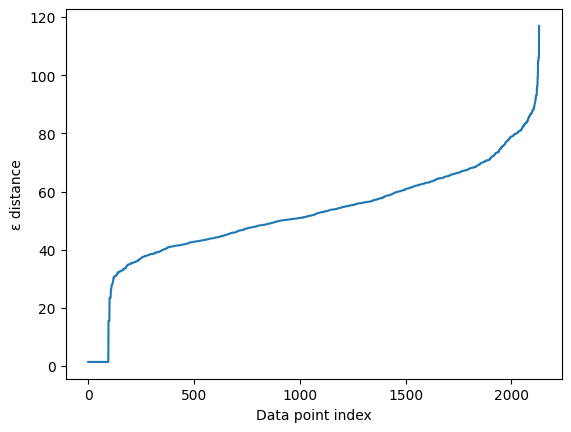

Suggested eps value: 1.4142424530197935
The suggested epsilon is: 1.4142424530197935


U hierarchical_model part...
Confusion Matrix (Hierarchical) Accuracy: 0.2106



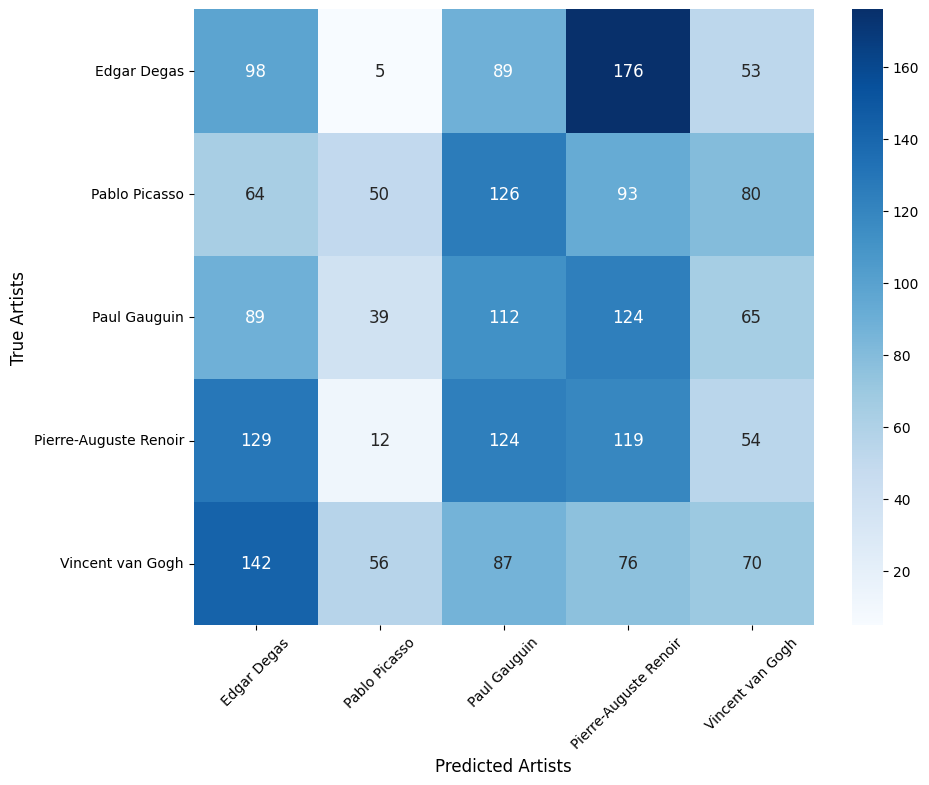

For n_clusters = 2, the average silhouette_score is : 0.25336152320854144
For n_clusters = 3, the average silhouette_score is : 0.05852862637455317
For n_clusters = 4, the average silhouette_score is : 0.00994314006835427
For n_clusters = 5, the average silhouette_score is : 0.013165825501897172
For n_clusters = 6, the average silhouette_score is : 0.014682402856908482
For n_clusters = 7, the average silhouette_score is : 0.018102253552769225
For n_clusters = 8, the average silhouette_score is : 0.019211934185249156
For n_clusters = 9, the average silhouette_score is : 0.021299795343764114
For n_clusters = 10, the average silhouette_score is : 0.01899957910652581


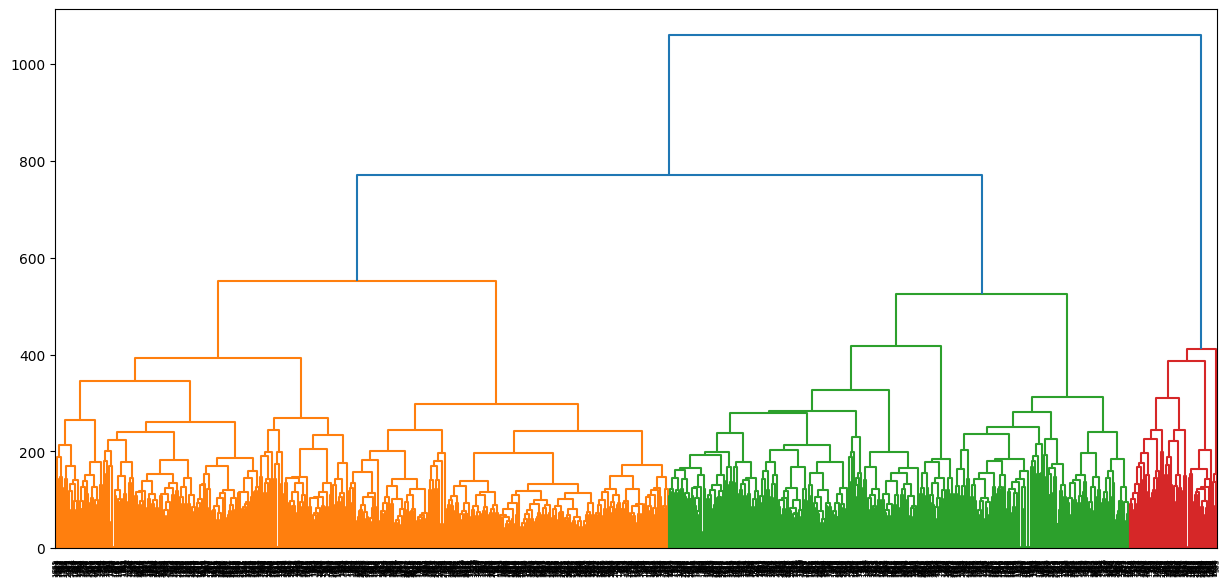

In [3]:


""" 
GMM INTRODUCED + ATTEMPTING SAMPLERS.
"""


""" //One-hot encode the specified column of the DataFrame. // 

:param df: pandas DataFrame containing the data
:param column_name: the name of the column to one-hot encode
:return: a DataFrame with one-hot encoded column and the encoder
"""


""" --- v1.1 change.
    # Create a mapping from class names to indices in the CSV file.
    # Use this mapping to fetch the correct genre for each image in the dataset.
            
    def load_and_encode_genres(excel_path, dataset, indices, column_name='genre'):
        df = pd.read_csv(excel_path)                  # Load your data into a DataFrame
        class_to_index = {row['name']: i for i, row in df.iterrows()}          # Create a mapping from class names to indices in the CSV file
    
        genres = []
           for idx in indices:                                     # Iterate over the indices and fetch the corresponding genre from the CSV file
            class_name = dataset.classes[dataset[idx][1]]            # Get the class name for the current image
            csv_index = class_to_index[class_name]                 # Get the corresponding index in the CSV file
            genre = df.loc[csv_index, column_name]                 # Fetch the genre
            genres.append(genre)
    
        genres = np.array(genres).reshape(-1, 1)                  # Convert genres list to a numpy array and reshape for encoding   
        encoder = OneHotEncoder()                              # Initialize OneHotEncoder // sparse=False
        genre_encoded = encoder.fit_transform(genres)              # Fit and transform the 'genre' column
        genre_encoded = genre_encoded.toarray()                   # Convert the sparse matrix to a dense array
        feature_names = encoder.get_feature_names_out([column_name])        # Get the feature names from encoder
    
        return genre_encoded, feature_names
"""


""" 
    ------------------------- ---------- v1. changes before 11Apr 7pm. Parameterizing.
    class CAE_3_16_WithLatent(nn.Module):
        def __init__(self):
            super(CAE_3_16_WithLatent, self).__init__()   
            
            self.encoder = nn.Sequential(                                       # step1: (n, 3, 64, 64)
                nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),           # (n, 16, 64, 64)
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),                          # (n, 16, 32, 32)
                nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),           # (n, 8, 32, 32)
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)                           # (n, 8, 16, 16)
            )
    
            self.flattened_size = 8 * 16 * 16                                   # j a helpful reference.        
            
            self.latent = nn.Sequential(
                nn.Linear( 8 * 16 * 16, 128 ),                                  # ( 2048 , 128 )     step2: 1st linear. 
                nn.ReLU(),
            )
    
            self.decoder = nn.Sequential(
                nn.Linear( 128, 8 * 16 * 16 ),                                                           # ( 128, 2048 )     step3: 2nd linear. 
                nn.ReLU(),
                nn.Unflatten(1, (8, 16, 16)),                                                            # : (n, 8, 16, 16)  step4: unflattening.
    
                nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1),                         # (n, 16, 32, 32)
                nn.ReLU(),
                nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),                         # (n, 3, 64, 64)
                nn.Sigmoid()
            )
    
             
        def forward(self, x):
            x = self.encoder(x) 
            x = x.view(-1, self.flattened_size)                                # step1: flattening. self.flattened_size = 8 * 16 * 16
            x = self.latent(x)
            x = self.decoder(x)
            return x
    
        def get_latent(self, x):
            x = self.encoder(x)
            x = x.view(-1, self.flattened_size)
            x = self.latent(x)                                                  # ( n, latent_dim, H, W)
            return x

"""



    

# ---------------------------------------------------------------------------------------------------------------------------------------------------------------
# Function for training classifier
def train_classifier(classifier, train_loader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        total_loss = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            # Forward pass
            features = model.get_latent(images).view(images.size(0), -1)
            predictions = classifier(features)
            # Loss and optimize
            loss = criterion(predictions, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        if epoch % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')


# Function to visualize classification results
def visualize_classification_results(classifier, data_loader):
    classifier.eval()  # Set the classifier to evaluation mode
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            features = model.get_latent(images).view(images.size(0), -1)  # Changed
            outputs = classifier(features)
            _, predicted = torch.max(outputs, 1)
            
            # Visualization code here
            plt.figure(figsize=(12, 8))
            for i in range(10):  # Display the first 10 images
                ax = plt.subplot(2, 5, i + 1)
                plt.imshow(images[i].cpu().numpy().transpose(1, 2, 0))
                ax.set_title(f'True: {labels[i].item()}, Pred: {predicted[i].item()}')
                plt.axis('off')
            plt.show()
            break  # Remove this break to visualize more than one batch


def evaluate_classifier(classifier, test_loader, criterion):
    classifier.eval()  # Set the classifier to evaluation mode
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        total_loss = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            features = model.get_latent(images).view(images.size(0), -1)  # Changed
            outputs = classifier(features)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total_loss += criterion(outputs, labels).item()
        avg_loss = total_loss / len(test_loader)
        accuracy = accuracy_score(all_labels, all_predictions)
        conf_matrix = confusion_matrix(all_labels, all_predictions)
    print(f'Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')
    print('Confusion Matrix:')
    print(conf_matrix)
    
    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', ax=ax, cmap='Blues')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_title('Confusion Matrix')
    plt.show()


def random_oversampling(features, labels):
    oversampler = RandomOverSampler(random_state=42)
    features_resampled, labels_resampled = oversampler.fit_resample(features, labels)
    return features_resampled, labels_resampled




# balance between increasing the width and depth of the network while keeping the model relatively compact to avoid overfitting and capture meaningful features.

# #  ONE last chance.. trial on 12th Apr 10PM. god give me one more chanceeee.
# class CAE_3_32_WithLatent(nn.Module):
#     def __init__(self, latent_dim=256):
#         super(CAE_3_32_WithLatent, self).__init__()
#         self.encoder = nn.Sequential(
#             nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1), nn.ReLU(),  # Output shape: (batch_size, 32, 64, 64)
#             nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1), nn.ReLU(),  # Output shape: (batch_size, 32, 64, 64)
#             nn.MaxPool2d(kernel_size=2, stride=2),  # Output shape: (batch_size, 32, 32, 32)
#             nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), nn.ReLU(),  # Output shape: (batch_size, 64, 32, 32)
#             nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), nn.ReLU(),  # Output shape: (batch_size, 64, 32, 32)
#             nn.MaxPool2d(kernel_size=2, stride=2),  # Output shape: (batch_size, 64, 16, 16)
#             nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), nn.ReLU(),  # Output shape: (batch_size, 128, 16, 16)
#             nn.MaxPool2d(kernel_size=2, stride=2)  # Output shape: (batch_size, 128, 8, 8)
#         )
#         self.flattened_size = 128 * 8 * 8
#         self.latent_dim = latent_dim
#         self.latent = nn.Sequential(
#             nn.Linear(self.flattened_size, self.latent_dim), nn.ReLU(),  # Output shape: (batch_size, latent_dim)
#         )
#         self.decoder = nn.Sequential(
#             nn.Linear(self.latent_dim, self.flattened_size), nn.ReLU(),  # Output shape: (batch_size, 128*8*8)
#             nn.Unflatten(1, (128, 8, 8)),  # Output shape: (batch_size, 128, 8, 8)
#             nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1), nn.ReLU(),  # Output shape: (batch_size, 64, 16, 16)
#             nn.ConvTranspose2d(64, 64, kernel_size=3, stride=1, padding=1), nn.ReLU(),  # Output shape: (batch_size, 64, 16, 16)
#             nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1), nn.ReLU(),  # Output shape: (batch_size, 32, 32, 32)
#             nn.ConvTranspose2d(32, 32, kernel_size=3, stride=1, padding=1), nn.ReLU(),  # Output shape: (batch_size, 32, 32, 32)
#             nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1), nn.Sigmoid()  # Output shape: (batch_size, 3, 64, 64)
#         )

#     def forward(self, x):
#         x = self.encoder(x)
#         x = x.view(-1, self.flattened_size)
#         x = self.latent(x)
#         x = self.decoder(x)
#         return x

#     def get_latent(self, x):
#         x = self.encoder(x)
#         x = x.view(-1, self.flattened_size)
#         x = self.latent(x)
#         return x



# class CAE_3_16_WithLatent(nn.Module):
#     def __init__(self, latent_dim=128):  # Add latent_dim as a parameter with a default value
#         super(CAE_3_16_WithLatent, self).__init__()
#         self.encoder = nn.Sequential(
#             nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1), nn.ReLU(), # Output shape: (batch_size, 16, 64, 64)
#             nn.MaxPool2d(kernel_size=2, stride=2),  # Output shape: (batch_size, 16, 32, 32)
#             nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1), nn.ReLU(), # Output shape: (batch_size, 8, 32, 32)
#             nn.MaxPool2d(kernel_size=2, stride=2)  # Output shape: (batch_size, 8, 16, 16)
#         )
#         self.flattened_size = 8 * 16 * 16
#         self.latent_dim = latent_dim  # Use the latent_dim parameter
#         self.latent = nn.Sequential(
#             nn.Linear(self.flattened_size, self.latent_dim), nn.ReLU(), # Output shape: (batch_size, latent_dim)
#              )
#         self.decoder = nn.Sequential(
#             nn.Linear(self.latent_dim, self.flattened_size), nn.ReLU(), # Output shape: (batch_size, 8*16*16)
#             nn.Unflatten(1, (8, 16, 16)),  # Output shape: (batch_size, 8, 16, 16)
#             nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1), nn.ReLU(), # Output shape: (batch_size, 16, 32, 32)
#             nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  nn.Sigmoid()  # Output shape: (batch_size, 3, 64, 64) , # Ensures output values are in the range [0, 1]
#         )

#     def forward(self, x):
#         x = self.encoder(x)  # Encode input
#         x = x.view(-1, self.flattened_size)  # Flatten encoded tensor
#         x = self.latent(x)  # Pass through latent layer
#         x = self.decoder(x)  # Decode to reconstruct input
#         return x

#     def get_latent(self, x):
#         x = self.encoder(x)  # Encode input
#         x = x.view(-1, self.flattened_size)  # Flatten encoded tensor
#         x = self.latent(x)  # Get latent representation
#         return x

    

# ---------------------------------------------------------------------------------------------------------------------------------------------------------------



"""
check the resulting clustering. If DBSCAN is labeling too many points as noise (label -1), consider decreasing eps. 
If it's making too many clusters, consider increasing eps. For min_samples, if the clusters are too sensitive to noise, increase the number, 
and if they are too generalized, decrease the number.
"""


"""
# Load and split dataset v1. -- for all.
def load_dataset(path, transform):
    dataset = ImageFolder(root=path, transform=transform)
    train_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)
    train_dataset = Subset(dataset, train_indices)
    test_dataset = Subset(dataset, test_indices)
    return train_dataset, test_dataset, train_indices, test_indices
"""

import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import random 
import torch
import torchvision
import torch.nn.functional as F
import torch.optim as optim
import multiprocessing as mp
import gc
import seaborn as sns
import torch
import torch.nn.functional as F
import os
import re
from sklearn.metrics import accuracy_score, confusion_matrix
from torch.cuda.amp import GradScaler, autocast
from sklearn.model_selection import train_test_split
from torchvision.datasets import ImageFolder
from time import time
from torchvision import transforms
from torch.utils.data import DataLoader,random_split,Subset,Dataset
from torch import nn
from sklearn.cluster import KMeans
import umap
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import WeightedRandomSampler
from collections import Counter
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN, AgglomerativeClustering





def calculate_dataset_stats(loader):
    mean = 0.0
    var = 0.0
    total_images_count = 0
    for images, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        var += ((images - mean.unsqueeze(1))**2).sum([0, 2])
        total_images_count += batch_samples

    mean /= total_images_count
    var /= total_images_count - 1
    std = torch.sqrt(var)

    return mean, std


def make_sampler(dataset):
    labels = [label for _, label in dataset]     # Get a list of labels from the dataset
    label_counts = Counter(labels)        # Count how often each label occurs
    label_weights = {label: 1.0/count for label, count in label_counts.items()}     # Calculate the inverse of each count to represent the weight    
    weights = [label_weights[label] for label in labels]     # Create a list of weights for each sample in the dataset
    sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)     # Create a sampler with these weights
    return sampler



def load_and_encode_genres(excel_path, dataset, indices, column_name='genre'):
    df = pd.read_csv(excel_path)               # Load your data into a DataFrame
    df = df[df['name'].isin(dataset.classes)]                # Filter DataFrame to only include classes present in the dataset
    df.reset_index(drop=True, inplace=True)                # Reset the index as we may have dropped some rows
    class_to_index = {row['name']: i for i, row in df.iterrows()}            # Create a mapping from class names to indices in the filtered CSV DataFrame
    genres = []             # Initialize an empty list to store genres
    for idx in indices:                # Iterate over the indices and fetch the corresponding genre from the filtered DataFrame
        class_name = dataset.classes[dataset[idx][1]]  # Get the class name for the current image
        csv_index = class_to_index.get(class_name)
        if csv_index is not None:
            genre = df.loc[csv_index, column_name]  # Fetch the genre
            genres.append(genre)
        else:
            raise ValueError(f"Class name '{class_name}' not found in the CSV file.")
    genres = np.array(genres).reshape(-1, 1)                 # Convert genres list to a numpy array and reshape for encoding
    encoder = OneHotEncoder()                            # Initialize OneHotEncoder
    genre_encoded = encoder.fit_transform(genres).toarray()        # Fit and transform the 'genre' column
    feature_names = encoder.get_feature_names_out([column_name])               # Get the feature names from the encoder
    def _print_class_mapping(dataset_classes, class_to_index): # Helper function
        print("Dataset Classes and Corresponding DataFrame Indices:")
        for class_name in dataset_classes:
            index = class_to_index.get(class_name, None)
            print(f"{class_name}: {index}")  
    _print_class_mapping(dataset.classes, class_to_index)   # Call the helper function
    
    return genre_encoded, feature_names




class CAE_128_WithLatent(nn.Module):
    def __init__(self, latent_dim=512):
        super(CAE_128_WithLatent, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # Output: (batch_size, 32, 64, 64)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # Output: (batch_size, 64, 32, 32)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: (batch_size, 64, 16, 16)
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # Output: (batch_size, 128, 8, 8)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: (batch_size, 128, 4, 4)
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # Output: (batch_size, 256, 4, 4)
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.latent_dim = latent_dim
        self.latent = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, self.latent_dim),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, 256 * 4 * 4),
            nn.ReLU(),
            nn.Unflatten(1, (256, 4, 4)),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # Output: (batch_size, 128, 8, 8)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # Output: (batch_size, 64, 16, 16)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # Output: (batch_size, 32, 32, 32)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2, padding=1),  # Output: (batch_size, 32, 64, 64)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),  # Output: (batch_size, 3, 128, 128)
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.latent(x)
        x = self.decoder(x)
        return x

    def get_latent(self, x):
        x = self.encoder(x)
        x = self.latent(x)
        return x




class Classifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Classifier, self).__init__()
        self.fc = nn.Linear(input_size, num_classes)
    def forward(self, x):
        return self.fc(x)




# Save model weights
def save_model(model, path):
    torch.save(model.state_dict(), path)

# Load model weights
def load_model(model, path):
    model.load_state_dict(torch.load(path))


# Train the model
def train_autoencoder_with_regularized_loss(model, train_loader, criterion, optimizer, num_epochs, lambda_reg):
    for epoch in range(num_epochs):
        for data in train_loader:
            img, _ = data
            img = img.to(device)
            # Forward pass
            output = model(img)
            # -- changing. loss = criterion(output, img) 
            recon_loss = criterion(output, img)                                      # // changing from casual to regularized loss.
            reg_loss = 0
            for param in model.parameters():
                reg_loss += torch.sum(param.pow(2))
            # Combine losses
            loss = recon_loss + lambda_reg * reg_loss
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if epoch % 2 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Combined Recon Loss: {loss.item():.4f}')


""" v1.1 train_autoencoder with no curves:
def train_autoencoder(model, train_loader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        for data in train_loader:
            img, _ = data
            img = img.to(device)
            
            output = model(img)
            recon_loss = criterion(output, img)
            optimizer.zero_grad()
            recon_loss.backward()
            optimizer.step()
        if epoch % 2 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Recon Loss: {recon_loss.item():.4f}')
"""


def train_autoencoder(model, train_loader, criterion, optimizer, num_epochs):
    train_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        for data in train_loader:
            img, _ = data
            img = img.to(device)
            output = model(img)
            loss = criterion(output, img)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        if epoch % 2 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}')

    # After training completes, plot the training loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training Loss Curve')
    plt.show()
    
    return train_losses


# Testing and visualization
def test_and_visualize(model, test_loader):
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            recon = model(data)
            break  # Only take the first batch for visualization

    
    plt.figure(figsize=(15, 5))
    num_images = 6
    for i in range(num_images):
        # Display original images
        ax = plt.subplot(2, num_images, i + 1)
        plt.imshow(data[i].cpu().numpy().transpose(1, 2, 0))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # Display reconstructed images
        ax = plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(recon[i].cpu().numpy().transpose(1, 2, 0))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
    plt.subplots_adjust(wspace=0.1, hspace=0.1)  # Adjust spacing to handle larger images if necessary
    plt.show()


# Function to extract features using the autoencoder's encoder
def extract_features(data_loader, model):
    features = []
    labels = []
    with torch.no_grad():
        for images, targets in data_loader:
            images = images.to(device)
            labels.extend(targets.numpy())
            latent_features = model.get_latent(images).view(images.size(0), -1)
            features.extend(latent_features.cpu().numpy())
    return np.array(features), np.array(labels)


# Function to predict labels using k-means
def predict_kmeans(data_loader, model, kmeans):
    predicted_labels = []
    true_labels = []
    with torch.no_grad():
        for images, targets in data_loader:
            images = images.to(device)
            true_labels.extend(targets.numpy())
            latent_features = model.get_latent(images).view(images.size(0), -1)
            latent_features = latent_features.cpu().numpy()
            cluster_labels = kmeans.predict(latent_features)
            predicted_labels.extend(cluster_labels)
    return np.array(predicted_labels), np.array(true_labels)                 # conv into np array and then send them as return values.




def train_and_evaluate_gmm(features, labels, num_classes):
    gmm = GaussianMixture(n_components=num_classes, random_state=42)
    gmm.fit(features)
    predicted_labels = gmm.predict(features)
    accuracy = accuracy_score(labels, predicted_labels)
    conf_matrix = confusion_matrix(labels, predicted_labels)
    
    return accuracy, conf_matrix, gmm   




# number of nearest neighbors UMAP will consider when constructing the initial high-dimensional graph.
# controls the tightness of UMAP's embedding. 
# With a larger value, points are clumped together more tightly in the low-dimensional representation, potentially obscuring detail.
# parameter specifies the number of dimensions in which to embed the data. For visualization, you usually set it to 2 (or 3 for 3D plots).



def visualize_umap(features, labels, artist_names, n_neighbors=15, min_dist=0.1, n_components=2):
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components, random_state=42)
    embedding = reducer.fit_transform(features)
    
    unique_labels = np.unique(labels)
    unique_artist_names = [artist_names[int(i)] for i in unique_labels]
    
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='Spectral', s=5)
    
    # Create a color bar with artist names
    colorbar = plt.colorbar(scatter, ticks=unique_labels)
    colorbar.set_label('Artists')
    colorbar.set_ticklabels(unique_artist_names)
    
    plt.title('UMAP projection of the dataset')
    plt.xlabel('UMAP dimension 1')
    plt.ylabel('UMAP dimension 2')
    plt.show()



def predict_and_visualize_kmeans(kmeans, data_loader, model, dataset, combined_features):
    true_labels = []
    predicted_labels = []
    with torch.no_grad():
        for images, targets in data_loader:
            images = images.to(device)
            true_labels.extend(targets.numpy())
    predicted_labels = kmeans.predict(combined_features)                                  # Make predictions using KMeans
    accuracy = accuracy_score(true_labels, predicted_labels)
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    print(f'\nK-means Accuracy: {accuracy:.4f}\n\n')

    visualize_conf_matrix(conf_matrix, dataset, title='Confusion Matrix')

    # plt.figure(figsize=(25, 22))    
    # sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
    # plt.xlabel('Predicted Artists')
    # plt.ylabel('True Artists')
    # plt.title('Confusion Matrix')
    # plt.xticks(rotation=90)                                                              # Rotate x-axis labels
    # plt.yticks(rotation=0)
    # plt.show()
    
    return accuracy, conf_matrix



def visualize_gmm_confmatrix(gmm_conf_matrix, gmm_accuracy, dataset):
    print(f"\n\nGMM Accuracy: {gmm_accuracy:.4f}\n\n")
    
    visualize_conf_matrix(gmm_conf_matrix, dataset, title='Confusion Matrix')
    # sns.heatmap(gmm_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
    # plt.xlabel('Predicted Artists')
    # plt.ylabel('True Artists')
    # plt.title('Confusion Matrix (GMM)')
    # plt.xticks(rotation=90)
    # plt.yticks(rotation=0)
    # plt.show()
        

def visualize_conf_matrix(conf_matrix, dataset, title='Confusion Matrix'):
    plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
    ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes, annot_kws={"size": 12})  # Increase annotation size
    plt.xlabel('Predicted Artists', fontsize=12)  # Adjust fontsize as needed
    plt.ylabel('True Artists', fontsize=12)  # Adjust fontsize as needed
    
    plt.xticks(rotation=45, fontsize=10)  # Rotate x-axis labels, adjust fontsize as needed
    plt.yticks(rotation=0, fontsize=10)  # Adjust fontsize as needed
    plt.show()


# DBSCAN doesn't predict new points and doesn't have labels, but we can use fit_predict to get labels for our training set
def train_and_evaluate_dbscan(features, eps, min_samples):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    predicted_labels = dbscan.fit_predict(features)
    # Since DBSCAN doesn't provide labels for all points (noise points get label -1),     # we cannot calculate accuracy as usual. We could assign them manually if needed.
    # Here, we will return the labels and the DBSCAN instance.
    return predicted_labels, dbscan


def visualize_clustering_confmatrix(true_labels, predicted_labels, dataset, title):
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    accuracy = accuracy_score(true_labels, predicted_labels)
    print(f'{title} Accuracy: {accuracy:.4f}\n')
    visualize_conf_matrix(conf_matrix, dataset, title=title)


def train_and_evaluate_hierarchical(features, num_classes):    # Hierarchical clustering
    hierarchical = AgglomerativeClustering(n_clusters=num_classes)
    predicted_labels = hierarchical.fit_predict(features)                     # Hierarchical clustering doesn't have an intrinsic 'predict' phase, it labels all in 'fit'

    return predicted_labels, hierarchical              # Hence, we'll return the labels and the model instance.


from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

def find_elbow_point(distances):
    second_derivative = np.diff(distances, n=2)            # Calculate the second derivative
    elbow_index = np.argmax(second_derivative)                # The 'elbow' point is where the second derivative is maximized
    return distances[elbow_index + 1]  # plus 1 due to the nature of diff reducing the array size


def plot_dbscan_eps(data, min_samples):
    nn = NearestNeighbors(n_neighbors=min_samples).fit(data)
    distances, indices = nn.kneighbors(data)
    sorted_distances = np.sort(distances[:,min_samples-1])
    
    plt.plot(sorted_distances)
    plt.ylabel('ε distance')
    plt.xlabel('Data point index')
    plt.show()

    eps_value = find_elbow_point(sorted_distances)               # Attempt to find the 'elbow' point programmatically
    print(f"Suggested eps value: {eps_value}")
    return eps_value


from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering

def get_silhouette_score(data, range_n_clusters):
    for n_clusters in range_n_clusters:
        clusterer = AgglomerativeClustering(n_clusters=n_clusters)
        cluster_labels = clusterer.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        print(f"For n_clusters = {n_clusters}, the average silhouette_score is : {silhouette_avg}")


from scipy.cluster.hierarchy import dendrogram, linkage

# plot_dendrogram is used to visually assess the possible number of clusters, which complements the silhouette score analysis well.

def plot_dendrogram(data, method='ward'):
    linked = linkage(data, method=method)
    plt.figure(figsize=(15, 7))
    dendrogram(linked,
               orientation='top',
               distance_sort='descending',
               show_leaf_counts=True)
    plt.show()

# -------------------------------------------------------------------------------------------------------------------------------------------------- !!
def load_dataset(path, train_transform, test_transform):
    dataset = ImageFolder(root=path, transform=train_transform)
    train_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)
    train_dataset = Subset(dataset, train_indices)
    test_dataset = Subset(dataset, test_indices)
    test_dataset.dataset.transform = test_transform
    return train_dataset, test_dataset, train_indices, test_indices



# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Main routine
def main():
    
    # Hyperparameters
    num_epochs = 150
    learning_rate = 0.001
    batch_size = 64
    lambda_reg = 0.0001  # Regularization strength --- failing entirely.
    # based on your latent space size
    latent_dim = 512  
    resize_param_for_transforms = 128
    
    # Data paths and transformations
    # og path with all datas.
    # path = r'C:\Users\joems\OneDrive\Desktop\FAI project s1\Best Artworks Of All Times\resized\resized_organized'

    path = r'C:\Users\joems\OneDrive\Desktop\FAI project s1\Best Artworks Of All Times\resized\resized_organized_top5'
    excel_path = r'C:\Users\joems\OneDrive\Desktop\FAI project s1\Best Artworks Of All Times\artists.csv'

    
    # Define transform
    transform = transforms.Compose([ transforms.Resize((resize_param_for_transforms, resize_param_for_transforms)), transforms.ToTensor() ])

    train_transform = transforms.Compose([
        transforms.Resize((resize_param_for_transforms, resize_param_for_transforms)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=5), # bad. transforms.RandomCrop(64, padding=4),
        transforms.ToTensor(),
    ])
    
    test_transform = transforms.Compose([
        transforms.Resize((resize_param_for_transforms, resize_param_for_transforms)),
        transforms.ToTensor(),
    ])
    

    # checks --
    df = pd.read_csv(excel_path)
    print(f"Number of entries in CSV file: {len(df)}")
    dataset = ImageFolder(root=path, transform=transform)
    print(f"Number of samples in image dataset: {len(dataset)}")

    # loaders. v1 older. # train_dataset, test_dataset, train_indices, test_indices = load_dataset(path, transform)
    train_dataset, test_dataset, train_indices, test_indices = load_dataset(path, train_transform, test_transform)

    # loaders v2 approach: samplers.
    # train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    # test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # introducing sampler code. only for train dataset.
    train_sampler = make_sampler(train_dataset)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler =train_sampler, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    
    num_classes = len(dataset.classes)           # !! dynamic num classes.
    

    # smaller model, 3 16, quick to train. favorite.
    # model = CAE_3_16_WithLatent().to(device)        # Initialize the model

    # slightly later. experiment time.
    model = CAE_128_WithLatent(latent_dim=latent_dim).to(device)        # Initialize the model

    
    criterion = nn.MSELoss()        # Loss and optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    lin_classification_criterion = nn.CrossEntropyLoss()         # Add a classification criterion for the classifier -- we are currently not using this linear classifier.

    # Load autoencoder weights if available. training part.
    if os.path.exists('autoencoder_model_CAE_128.ckpt'):
        load_model(model, 'autoencoder_model_CAE_128.ckpt')
    else:
        print("Training autoencoder...")
        train_autoencoder(model, train_loader, criterion, optimizer, num_epochs)
        save_model(model, 'autoencoder_model_CAE_128.ckpt')

    
    model.eval()

    # Step 9: Visualization
    print("Visualizing reconstructions...")
    test_and_visualize(model, test_loader)

    # Step 4: Feature Extraction  -- are of this shape. [batch_size, latent_dimensions]. 
    train_features, train_labels = extract_features(train_loader, model)
    test_features, test_labels = extract_features(test_loader, model)
    
    # Step 5: Genre Encoding --- flawed approach without mapping   # genre_encoded_train, _ = load_and_encode_genres(excel_path, train_indices)        
    # Step 5: Genre Encoding -- v1.         # genre_encoded_train, _ = load_and_encode_genres(excel_path, train_dataset.dataset, train_indices) # genre_encoded_test, _ = load_and_encode_genres(excel_path, test_dataset.dataset, test_indices)

    genre_encoded_train, feature_names_train = load_and_encode_genres(excel_path, train_dataset.dataset, train_indices)
    genre_encoded_test, feature_names_test = load_and_encode_genres(excel_path, test_dataset.dataset, test_indices)

    # Step 6: Feature Combination
    combined_train_features = np.hstack((train_features, genre_encoded_train))
    combined_test_features = np.hstack((test_features, genre_encoded_test))

    
    # Step 7: Clustering, kmeans initialization
    kmeans = KMeans(n_clusters=num_classes, random_state=42)
    kmeans.fit(combined_train_features)

    # Step 8: Evaluation # previous code: accuracy, conf_matrix = predict_and_visualize_kmeans(kmeans, test_loader, model, test_dataset.dataset)
    accuracy, conf_matrix = predict_and_visualize_kmeans(kmeans, test_loader, model, test_dataset.dataset, combined_test_features)

    # Step 10: UMAP presentation.
    print(f"\n\nUMAP Feature Extraction part...") 
    visualize_umap(combined_test_features, test_labels, test_dataset.dataset.classes)
    print(f"\n\nUMAP Feature Extraction End...")

    # Step 11:
    gmm_accuracy, gmm_conf_matrix, gmm = train_and_evaluate_gmm(combined_train_features, train_labels, num_classes)
    # Step 12: Visualization for GMM
    visualize_gmm_confmatrix(gmm_conf_matrix, gmm_accuracy, test_dataset.dataset)


    print(f"\n\nUMAP DBSCAN part...") 
    # Step 13: DBSCAN and hierarchial clustering - AgglomerativeClustering
    suggested_eps = plot_dbscan_eps(combined_train_features, min_samples=5)                         # Use an appropriate min_samples value    
    print(f"The suggested epsilon is: {suggested_eps}")
    dbscan_labels, dbscan_model = train_and_evaluate_dbscan(combined_train_features, eps=suggested_eps, min_samples=5)

    # DBSCAN confusion matrix doesnt really make any sense.
    # visualize_clustering_confmatrix(train_labels, dbscan_labels, train_dataset.dataset, title='Confusion Matrix (DBSCAN)')

    print(f"\n\nU hierarchical_model part...") 
    hierarchical_labels, hierarchical_model = train_and_evaluate_hierarchical(combined_train_features, num_classes=num_classes)
    visualize_clustering_confmatrix(train_labels, hierarchical_labels, train_dataset.dataset, title='Confusion Matrix (Hierarchical)')
    
    get_silhouette_score(combined_train_features, range(2, 11))                       # Check silhouette score for different numbers of clusters
    plot_dendrogram(combined_train_features)                                          # Plot dendrogram for your dataset




if __name__ == '__main__':
    main()


Using device: cuda
Number of entries in CSV file: 50
Number of samples in image dataset: 2665
Training autoencoder...
Epoch [1/150], Train Loss: 0.0414
Epoch [3/150], Train Loss: 0.0274
Epoch [5/150], Train Loss: 0.0253
Epoch [7/150], Train Loss: 0.0235
Epoch [9/150], Train Loss: 0.0214
Epoch [11/150], Train Loss: 0.0189
Epoch [13/150], Train Loss: 0.0180
Epoch [15/150], Train Loss: 0.0174
Epoch [17/150], Train Loss: 0.0173
Epoch [19/150], Train Loss: 0.0167
Epoch [21/150], Train Loss: 0.0163
Epoch [23/150], Train Loss: 0.0153
Epoch [25/150], Train Loss: 0.0148
Epoch [27/150], Train Loss: 0.0151
Epoch [29/150], Train Loss: 0.0144
Epoch [31/150], Train Loss: 0.0142
Epoch [33/150], Train Loss: 0.0137
Epoch [35/150], Train Loss: 0.0138
Epoch [37/150], Train Loss: 0.0132
Epoch [39/150], Train Loss: 0.0128
Epoch [41/150], Train Loss: 0.0129
Epoch [43/150], Train Loss: 0.0124
Epoch [45/150], Train Loss: 0.0121
Epoch [47/150], Train Loss: 0.0120
Epoch [49/150], Train Loss: 0.0115
Epoch [51/15

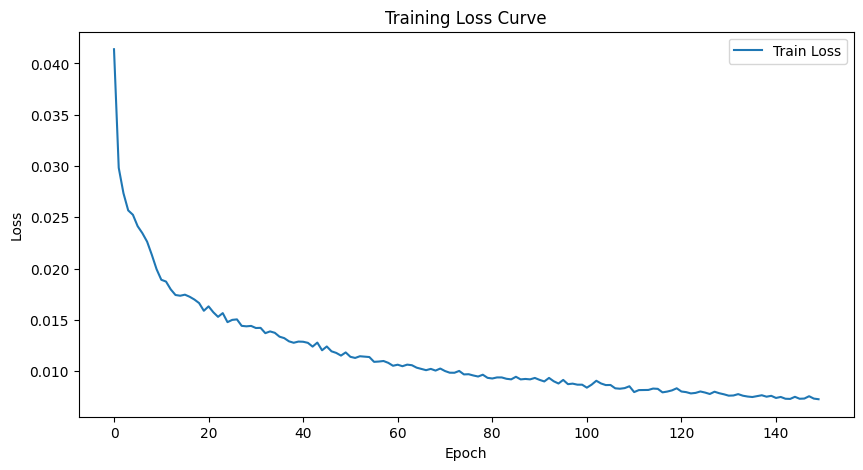

Visualizing reconstructions...


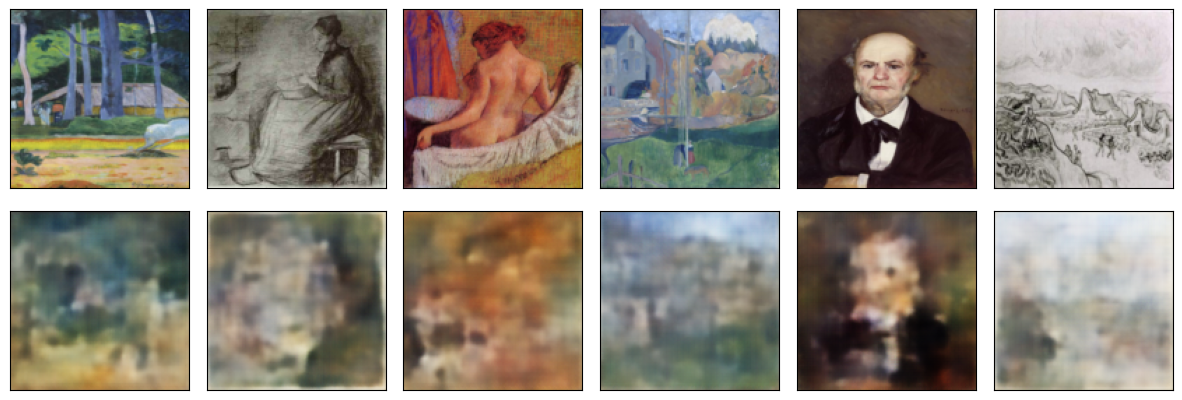


K-means Accuracy: 0.1482




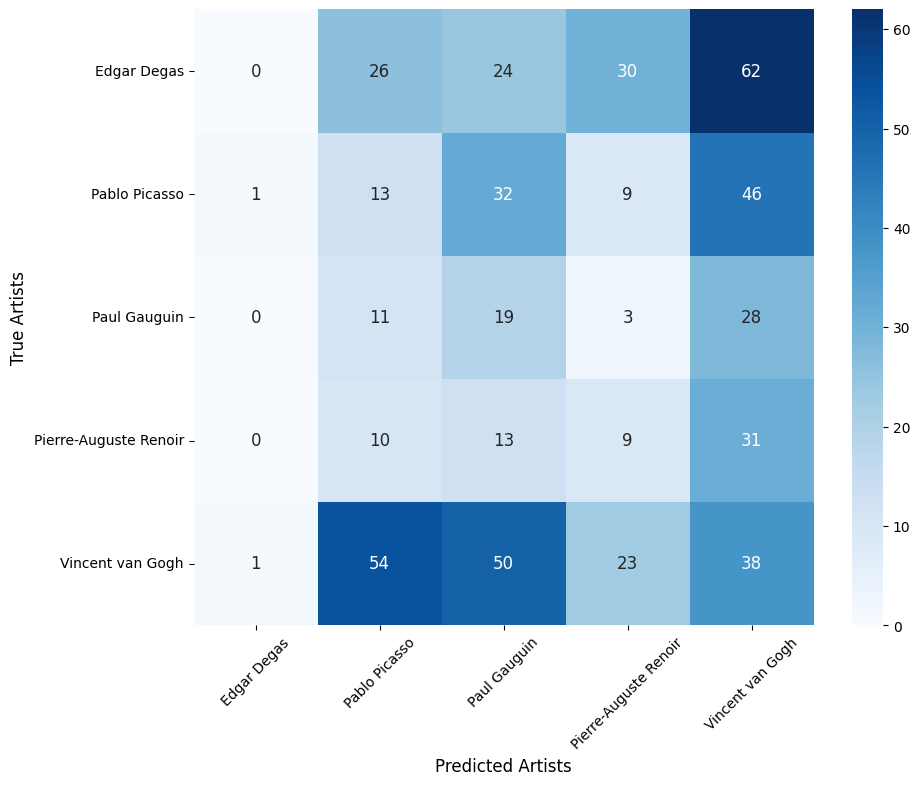



UMAP Feature Extraction part...


C:\Users\joems\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


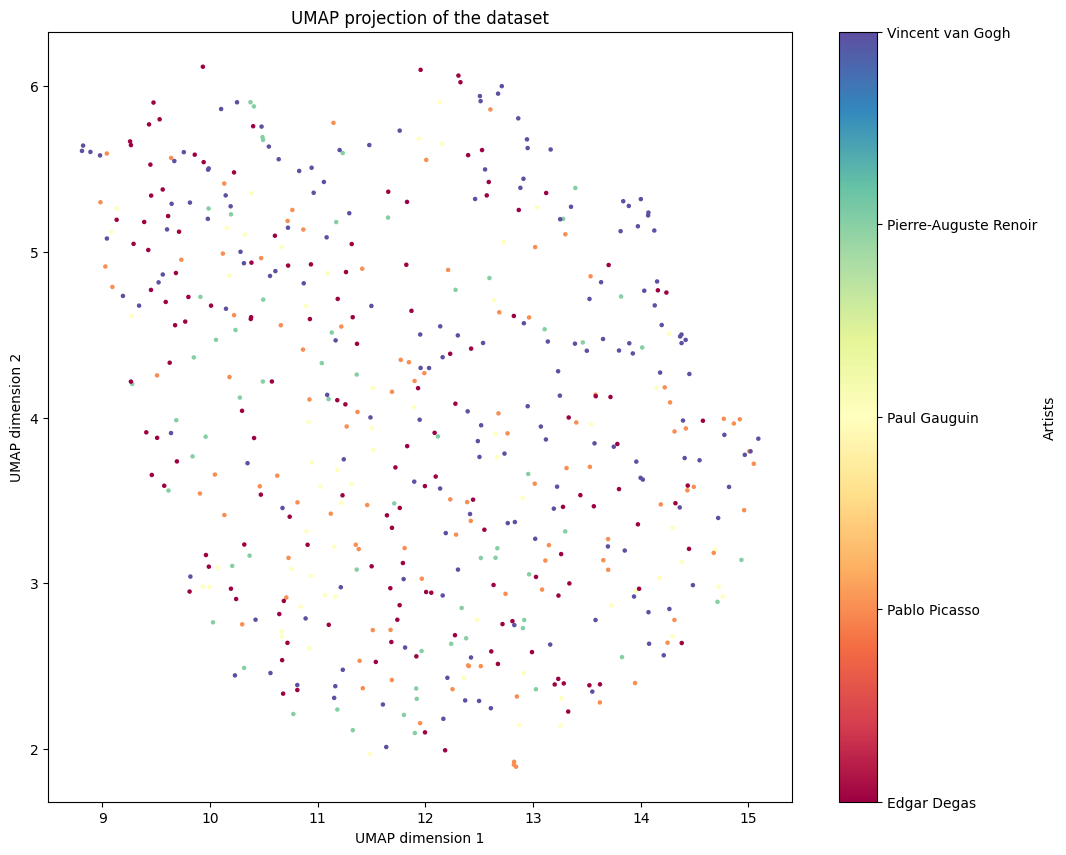



UMAP Feature Extraction End...


GMM Accuracy: 0.1309




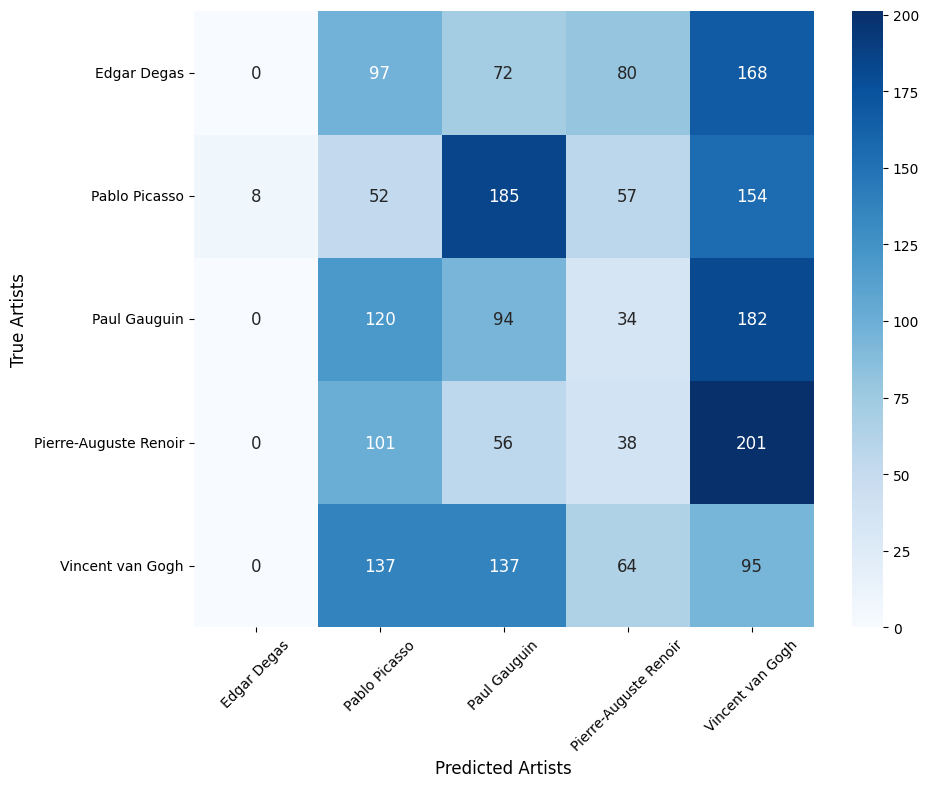



UMAP DBSCAN part...


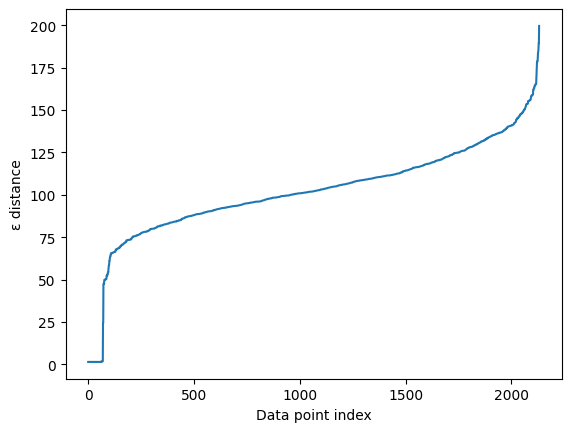

Suggested eps value: 24.388959936515306
The suggested epsilon is: 24.388959936515306


U hierarchical_model part...
Confusion Matrix (Hierarchical) Accuracy: 0.1900



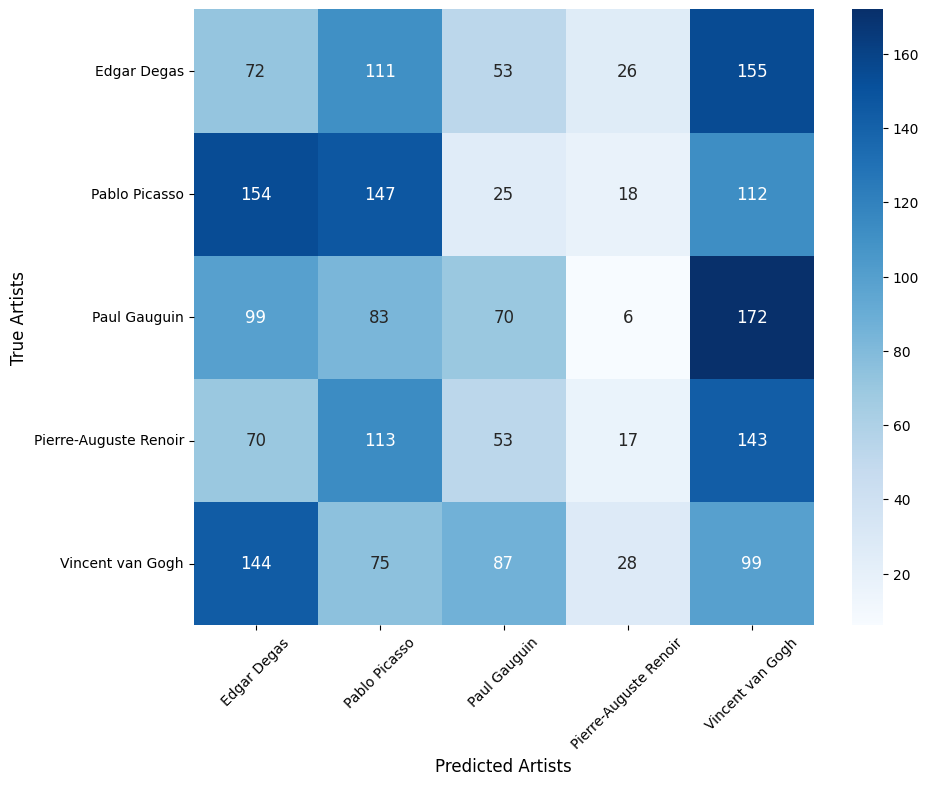

For n_clusters = 2, the average silhouette_score is : 0.026245017258134138
For n_clusters = 3, the average silhouette_score is : 0.001930300277040368
For n_clusters = 4, the average silhouette_score is : 0.008019379688684932
For n_clusters = 5, the average silhouette_score is : 0.010842919364220644
For n_clusters = 6, the average silhouette_score is : -0.012434710480062405
For n_clusters = 7, the average silhouette_score is : -0.008929710741076236
For n_clusters = 8, the average silhouette_score is : -0.007628700152449694
For n_clusters = 9, the average silhouette_score is : -0.007625667784707809
For n_clusters = 10, the average silhouette_score is : -0.015221922394052111


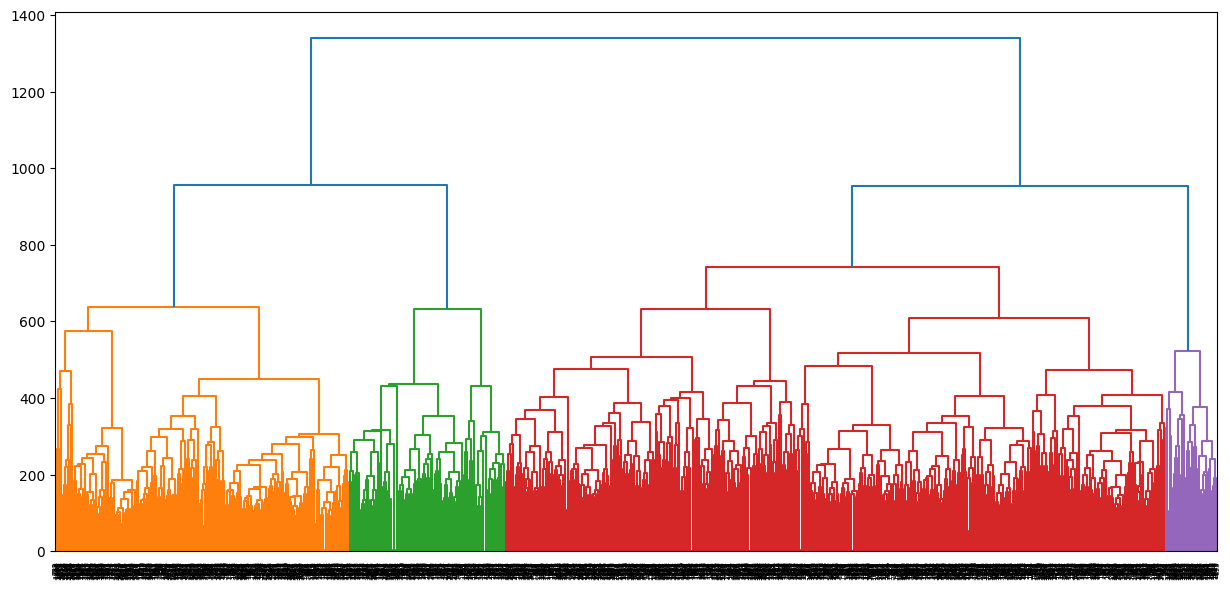

In [3]:





""" 
GMM INTRODUCED + ATTEMPTING SAMPLERS.
"""


""" //One-hot encode the specified column of the DataFrame. // 

:param df: pandas DataFrame containing the data
:param column_name: the name of the column to one-hot encode
:return: a DataFrame with one-hot encoded column and the encoder
"""


""" --- v1.1 change.
    # Create a mapping from class names to indices in the CSV file.
    # Use this mapping to fetch the correct genre for each image in the dataset.
            
    def load_and_encode_genres(excel_path, dataset, indices, column_name='genre'):
        df = pd.read_csv(excel_path)                  # Load your data into a DataFrame
        class_to_index = {row['name']: i for i, row in df.iterrows()}          # Create a mapping from class names to indices in the CSV file
    
        genres = []
           for idx in indices:                                     # Iterate over the indices and fetch the corresponding genre from the CSV file
            class_name = dataset.classes[dataset[idx][1]]            # Get the class name for the current image
            csv_index = class_to_index[class_name]                 # Get the corresponding index in the CSV file
            genre = df.loc[csv_index, column_name]                 # Fetch the genre
            genres.append(genre)
    
        genres = np.array(genres).reshape(-1, 1)                  # Convert genres list to a numpy array and reshape for encoding   
        encoder = OneHotEncoder()                              # Initialize OneHotEncoder // sparse=False
        genre_encoded = encoder.fit_transform(genres)              # Fit and transform the 'genre' column
        genre_encoded = genre_encoded.toarray()                   # Convert the sparse matrix to a dense array
        feature_names = encoder.get_feature_names_out([column_name])        # Get the feature names from encoder
    
        return genre_encoded, feature_names
"""


""" 
    ------------------------- ---------- v1. changes before 11Apr 7pm. Parameterizing.
    class CAE_3_16_WithLatent(nn.Module):
        def __init__(self):
            super(CAE_3_16_WithLatent, self).__init__()   
            
            self.encoder = nn.Sequential(                                       # step1: (n, 3, 64, 64)
                nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),           # (n, 16, 64, 64)
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),                          # (n, 16, 32, 32)
                nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),           # (n, 8, 32, 32)
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)                           # (n, 8, 16, 16)
            )
    
            self.flattened_size = 8 * 16 * 16                                   # j a helpful reference.        
            
            self.latent = nn.Sequential(
                nn.Linear( 8 * 16 * 16, 128 ),                                  # ( 2048 , 128 )     step2: 1st linear. 
                nn.ReLU(),
            )
    
            self.decoder = nn.Sequential(
                nn.Linear( 128, 8 * 16 * 16 ),                                                           # ( 128, 2048 )     step3: 2nd linear. 
                nn.ReLU(),
                nn.Unflatten(1, (8, 16, 16)),                                                            # : (n, 8, 16, 16)  step4: unflattening.
    
                nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1),                         # (n, 16, 32, 32)
                nn.ReLU(),
                nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),                         # (n, 3, 64, 64)
                nn.Sigmoid()
            )
    
             
        def forward(self, x):
            x = self.encoder(x) 
            x = x.view(-1, self.flattened_size)                                # step1: flattening. self.flattened_size = 8 * 16 * 16
            x = self.latent(x)
            x = self.decoder(x)
            return x
    
        def get_latent(self, x):
            x = self.encoder(x)
            x = x.view(-1, self.flattened_size)
            x = self.latent(x)                                                  # ( n, latent_dim, H, W)
            return x

"""



    

# ---------------------------------------------------------------------------------------------------------------------------------------------------------------
# Function for training classifier
def train_classifier(classifier, train_loader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        total_loss = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            # Forward pass
            features = model.get_latent(images).view(images.size(0), -1)
            predictions = classifier(features)
            # Loss and optimize
            loss = criterion(predictions, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        if epoch % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')


# Function to visualize classification results
def visualize_classification_results(classifier, data_loader):
    classifier.eval()  # Set the classifier to evaluation mode
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            features = model.get_latent(images).view(images.size(0), -1)  # Changed
            outputs = classifier(features)
            _, predicted = torch.max(outputs, 1)
            
            # Visualization code here
            plt.figure(figsize=(12, 8))
            for i in range(10):  # Display the first 10 images
                ax = plt.subplot(2, 5, i + 1)
                plt.imshow(images[i].cpu().numpy().transpose(1, 2, 0))
                ax.set_title(f'True: {labels[i].item()}, Pred: {predicted[i].item()}')
                plt.axis('off')
            plt.show()
            break  # Remove this break to visualize more than one batch


def evaluate_classifier(classifier, test_loader, criterion):
    classifier.eval()  # Set the classifier to evaluation mode
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        total_loss = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            features = model.get_latent(images).view(images.size(0), -1)  # Changed
            outputs = classifier(features)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total_loss += criterion(outputs, labels).item()
        avg_loss = total_loss / len(test_loader)
        accuracy = accuracy_score(all_labels, all_predictions)
        conf_matrix = confusion_matrix(all_labels, all_predictions)
    print(f'Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')
    print('Confusion Matrix:')
    print(conf_matrix)
    
    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', ax=ax, cmap='Blues')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_title('Confusion Matrix')
    plt.show()


def random_oversampling(features, labels):
    oversampler = RandomOverSampler(random_state=42)
    features_resampled, labels_resampled = oversampler.fit_resample(features, labels)
    return features_resampled, labels_resampled




# balance between increasing the width and depth of the network while keeping the model relatively compact to avoid overfitting and capture meaningful features.

# #  ONE last chance.. trial on 12th Apr 10PM. god give me one more chanceeee.
# class CAE_3_32_WithLatent(nn.Module):
#     def __init__(self, latent_dim=256):
#         super(CAE_3_32_WithLatent, self).__init__()
#         self.encoder = nn.Sequential(
#             nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1), nn.ReLU(),  # Output shape: (batch_size, 32, 64, 64)
#             nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1), nn.ReLU(),  # Output shape: (batch_size, 32, 64, 64)
#             nn.MaxPool2d(kernel_size=2, stride=2),  # Output shape: (batch_size, 32, 32, 32)
#             nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), nn.ReLU(),  # Output shape: (batch_size, 64, 32, 32)
#             nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), nn.ReLU(),  # Output shape: (batch_size, 64, 32, 32)
#             nn.MaxPool2d(kernel_size=2, stride=2),  # Output shape: (batch_size, 64, 16, 16)
#             nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), nn.ReLU(),  # Output shape: (batch_size, 128, 16, 16)
#             nn.MaxPool2d(kernel_size=2, stride=2)  # Output shape: (batch_size, 128, 8, 8)
#         )
#         self.flattened_size = 128 * 8 * 8
#         self.latent_dim = latent_dim
#         self.latent = nn.Sequential(
#             nn.Linear(self.flattened_size, self.latent_dim), nn.ReLU(),  # Output shape: (batch_size, latent_dim)
#         )
#         self.decoder = nn.Sequential(
#             nn.Linear(self.latent_dim, self.flattened_size), nn.ReLU(),  # Output shape: (batch_size, 128*8*8)
#             nn.Unflatten(1, (128, 8, 8)),  # Output shape: (batch_size, 128, 8, 8)
#             nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1), nn.ReLU(),  # Output shape: (batch_size, 64, 16, 16)
#             nn.ConvTranspose2d(64, 64, kernel_size=3, stride=1, padding=1), nn.ReLU(),  # Output shape: (batch_size, 64, 16, 16)
#             nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1), nn.ReLU(),  # Output shape: (batch_size, 32, 32, 32)
#             nn.ConvTranspose2d(32, 32, kernel_size=3, stride=1, padding=1), nn.ReLU(),  # Output shape: (batch_size, 32, 32, 32)
#             nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1), nn.Sigmoid()  # Output shape: (batch_size, 3, 64, 64)
#         )

#     def forward(self, x):
#         x = self.encoder(x)
#         x = x.view(-1, self.flattened_size)
#         x = self.latent(x)
#         x = self.decoder(x)
#         return x

#     def get_latent(self, x):
#         x = self.encoder(x)
#         x = x.view(-1, self.flattened_size)
#         x = self.latent(x)
#         return x



# class CAE_3_16_WithLatent(nn.Module):
#     def __init__(self, latent_dim=128):  # Add latent_dim as a parameter with a default value
#         super(CAE_3_16_WithLatent, self).__init__()
#         self.encoder = nn.Sequential(
#             nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1), nn.ReLU(), # Output shape: (batch_size, 16, 64, 64)
#             nn.MaxPool2d(kernel_size=2, stride=2),  # Output shape: (batch_size, 16, 32, 32)
#             nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1), nn.ReLU(), # Output shape: (batch_size, 8, 32, 32)
#             nn.MaxPool2d(kernel_size=2, stride=2)  # Output shape: (batch_size, 8, 16, 16)
#         )
#         self.flattened_size = 8 * 16 * 16
#         self.latent_dim = latent_dim  # Use the latent_dim parameter
#         self.latent = nn.Sequential(
#             nn.Linear(self.flattened_size, self.latent_dim), nn.ReLU(), # Output shape: (batch_size, latent_dim)
#              )
#         self.decoder = nn.Sequential(
#             nn.Linear(self.latent_dim, self.flattened_size), nn.ReLU(), # Output shape: (batch_size, 8*16*16)
#             nn.Unflatten(1, (8, 16, 16)),  # Output shape: (batch_size, 8, 16, 16)
#             nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1), nn.ReLU(), # Output shape: (batch_size, 16, 32, 32)
#             nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  nn.Sigmoid()  # Output shape: (batch_size, 3, 64, 64) , # Ensures output values are in the range [0, 1]
#         )

#     def forward(self, x):
#         x = self.encoder(x)  # Encode input
#         x = x.view(-1, self.flattened_size)  # Flatten encoded tensor
#         x = self.latent(x)  # Pass through latent layer
#         x = self.decoder(x)  # Decode to reconstruct input
#         return x

#     def get_latent(self, x):
#         x = self.encoder(x)  # Encode input
#         x = x.view(-1, self.flattened_size)  # Flatten encoded tensor
#         x = self.latent(x)  # Get latent representation
#         return x

    

# ---------------------------------------------------------------------------------------------------------------------------------------------------------------



"""
check the resulting clustering. If DBSCAN is labeling too many points as noise (label -1), consider decreasing eps. 
If it's making too many clusters, consider increasing eps. For min_samples, if the clusters are too sensitive to noise, increase the number, 
and if they are too generalized, decrease the number.
"""


"""
# Load and split dataset v1. -- for all.
def load_dataset(path, transform):
    dataset = ImageFolder(root=path, transform=transform)
    train_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)
    train_dataset = Subset(dataset, train_indices)
    test_dataset = Subset(dataset, test_indices)
    return train_dataset, test_dataset, train_indices, test_indices
"""

import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import random 
import torch
import torchvision
import torch.nn.functional as F
import torch.optim as optim
import multiprocessing as mp
import gc
import seaborn as sns
import torch
import torch.nn.functional as F
import os
import re
from sklearn.metrics import accuracy_score, confusion_matrix
from torch.cuda.amp import GradScaler, autocast
from sklearn.model_selection import train_test_split
from torchvision.datasets import ImageFolder
from time import time
from torchvision import transforms
from torch.utils.data import DataLoader,random_split,Subset,Dataset
from torch import nn
from sklearn.cluster import KMeans
import umap
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import WeightedRandomSampler
from collections import Counter
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN, AgglomerativeClustering

from sklearn.preprocessing import MultiLabelBinarizer





def calculate_dataset_stats(loader):
    mean = 0.0
    var = 0.0
    total_images_count = 0
    for images, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        var += ((images - mean.unsqueeze(1))**2).sum([0, 2])
        total_images_count += batch_samples

    mean /= total_images_count
    var /= total_images_count - 1
    std = torch.sqrt(var)

    return mean, std


def make_sampler(dataset):
    labels = [label for _, label in dataset]     # Get a list of labels from the dataset
    label_counts = Counter(labels)        # Count how often each label occurs
    label_weights = {label: 1.0/count for label, count in label_counts.items()}     # Calculate the inverse of each count to represent the weight    
    weights = [label_weights[label] for label in labels]     # Create a list of weights for each sample in the dataset
    sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)     # Create a sampler with these weights
    return sampler




# def load_and_encode_genres(excel_path, dataset, indices, column_name='genre'):
#     df = pd.read_csv(excel_path)               # Load your data into a DataFrame
#     df = df[df['name'].isin(dataset.classes)]                # Filter DataFrame to only include classes present in the dataset
#     df.reset_index(drop=True, inplace=True)                # Reset the index as we may have dropped some rows
#     class_to_index = {row['name']: i for i, row in df.iterrows()}            # Create a mapping from class names to indices in the filtered CSV DataFrame
#     genres = []             # Initialize an empty list to store genres
#     for idx in indices:                # Iterate over the indices and fetch the corresponding genre from the filtered DataFrame
#         class_name = dataset.classes[dataset[idx][1]]  # Get the class name for the current image
#         csv_index = class_to_index.get(class_name)
#         if csv_index is not None:
#             genre = df.loc[csv_index, column_name]  # Fetch the genre
#             genres.append(genre)
#         else:
#             raise ValueError(f"Class name '{class_name}' not found in the CSV file.")
#     genres = np.array(genres).reshape(-1, 1)                 # Convert genres list to a numpy array and reshape for encoding
#     encoder = OneHotEncoder()                            # Initialize OneHotEncoder
#     genre_encoded = encoder.fit_transform(genres).toarray()        # Fit and transform the 'genre' column
#     feature_names = encoder.get_feature_names_out([column_name])               # Get the feature names from the encoder
#     def _print_class_mapping(dataset_classes, class_to_index): # Helper function
#         print("Dataset Classes and Corresponding DataFrame Indices:")
#         for class_name in dataset_classes:
#             index = class_to_index.get(class_name, None)
#             print(f"{class_name}: {index}")  
#     _print_class_mapping(dataset.classes, class_to_index)   # Call the helper function
    
#     return genre_encoded, feature_names



# Simulated function for genre loading and encoding to replace the existing one
def load_and_encode_genres(excel_path, dataset, indices, column_name='genre'):
    df = pd.read_csv(excel_path)  # Load the dataset information
    df = df[df['name'].isin(dataset.classes)]  # Filter based on the classes in the dataset
    df.reset_index(drop=True, inplace=True)
    
    # Mapping from class names to indices in the DataFrame
    class_to_index = {row['name']: i for i, row in df.iterrows()}
    
    # Extract genres for the indices provided, each artist may have multiple genres
    genres = []
    for idx in indices:
        class_name = dataset.classes[dataset[idx][1]]
        csv_index = class_to_index.get(class_name)
        if csv_index is not None:
            genre_list = df.loc[csv_index, column_name].split(',')  # Split multiple genres into a list
            genres.append(genre_list)
        else:
            raise ValueError(f"Class name '{class_name}' not found in the CSV file.")
    
    # Initialize MultiLabelBinarizer for multi-label genre encoding
    mlb = MultiLabelBinarizer()
    genre_encoded = mlb.fit_transform(genres)  # Fit and transform to get the encoded genres
    feature_names = mlb.classes_  # Get the names of the features after encoding
    
    return genre_encoded, feature_names



class CAE_128_WithLatent(nn.Module):
    def __init__(self, latent_dim=512):
        super(CAE_128_WithLatent, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # Output: (batch_size, 32, 64, 64)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # Output: (batch_size, 64, 32, 32)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: (batch_size, 64, 16, 16)
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # Output: (batch_size, 128, 8, 8)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: (batch_size, 128, 4, 4)
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # Output: (batch_size, 256, 4, 4)
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.latent_dim = latent_dim
        self.latent = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, self.latent_dim),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, 256 * 4 * 4),
            nn.ReLU(),
            nn.Unflatten(1, (256, 4, 4)),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # Output: (batch_size, 128, 8, 8)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # Output: (batch_size, 64, 16, 16)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # Output: (batch_size, 32, 32, 32)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2, padding=1),  # Output: (batch_size, 32, 64, 64)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),  # Output: (batch_size, 3, 128, 128)
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.latent(x)
        x = self.decoder(x)
        return x

    def get_latent(self, x):
        x = self.encoder(x)
        x = self.latent(x)
        return x




class Classifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Classifier, self).__init__()
        self.fc = nn.Linear(input_size, num_classes)
    def forward(self, x):
        return self.fc(x)




# Save model weights
def save_model(model, path):
    torch.save(model.state_dict(), path)

# Load model weights
def load_model(model, path):
    model.load_state_dict(torch.load(path))


# Train the model
def train_autoencoder_with_regularized_loss(model, train_loader, criterion, optimizer, num_epochs, lambda_reg):
    for epoch in range(num_epochs):
        for data in train_loader:
            img, _ = data
            img = img.to(device)
            # Forward pass
            output = model(img)
            # -- changing. loss = criterion(output, img) 
            recon_loss = criterion(output, img)                                      # // changing from casual to regularized loss.
            reg_loss = 0
            for param in model.parameters():
                reg_loss += torch.sum(param.pow(2))
            # Combine losses
            loss = recon_loss + lambda_reg * reg_loss
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if epoch % 2 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Combined Recon Loss: {loss.item():.4f}')


""" v1.1 train_autoencoder with no curves:
def train_autoencoder(model, train_loader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        for data in train_loader:
            img, _ = data
            img = img.to(device)
            
            output = model(img)
            recon_loss = criterion(output, img)
            optimizer.zero_grad()
            recon_loss.backward()
            optimizer.step()
        if epoch % 2 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Recon Loss: {recon_loss.item():.4f}')
"""


def train_autoencoder(model, train_loader, criterion, optimizer, num_epochs):
    train_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        for data in train_loader:
            img, _ = data
            img = img.to(device)
            output = model(img)
            loss = criterion(output, img)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        if epoch % 2 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}')

    # After training completes, plot the training loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training Loss Curve')
    plt.show()
    
    return train_losses


# Testing and visualization
def test_and_visualize(model, test_loader):
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            recon = model(data)
            break  # Only take the first batch for visualization

    
    plt.figure(figsize=(15, 5))
    num_images = 6
    for i in range(num_images):
        # Display original images
        ax = plt.subplot(2, num_images, i + 1)
        plt.imshow(data[i].cpu().numpy().transpose(1, 2, 0))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # Display reconstructed images
        ax = plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(recon[i].cpu().numpy().transpose(1, 2, 0))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
    plt.subplots_adjust(wspace=0.1, hspace=0.1)  # Adjust spacing to handle larger images if necessary
    plt.show()


# Function to extract features using the autoencoder's encoder
def extract_features(data_loader, model):
    features = []
    labels = []
    with torch.no_grad():
        for images, targets in data_loader:
            images = images.to(device)
            labels.extend(targets.numpy())
            latent_features = model.get_latent(images).view(images.size(0), -1)
            features.extend(latent_features.cpu().numpy())
    return np.array(features), np.array(labels)


# Function to predict labels using k-means
def predict_kmeans(data_loader, model, kmeans):
    predicted_labels = []
    true_labels = []
    with torch.no_grad():
        for images, targets in data_loader:
            images = images.to(device)
            true_labels.extend(targets.numpy())
            latent_features = model.get_latent(images).view(images.size(0), -1)
            latent_features = latent_features.cpu().numpy()
            cluster_labels = kmeans.predict(latent_features)
            predicted_labels.extend(cluster_labels)
    return np.array(predicted_labels), np.array(true_labels)                 # conv into np array and then send them as return values.




def train_and_evaluate_gmm(features, labels, num_classes):
    gmm = GaussianMixture(n_components=num_classes, random_state=42)
    gmm.fit(features)
    predicted_labels = gmm.predict(features)
    accuracy = accuracy_score(labels, predicted_labels)
    conf_matrix = confusion_matrix(labels, predicted_labels)
    
    return accuracy, conf_matrix, gmm   




# number of nearest neighbors UMAP will consider when constructing the initial high-dimensional graph.
# controls the tightness of UMAP's embedding. 
# With a larger value, points are clumped together more tightly in the low-dimensional representation, potentially obscuring detail.
# parameter specifies the number of dimensions in which to embed the data. For visualization, you usually set it to 2 (or 3 for 3D plots).



def visualize_umap(features, labels, artist_names, n_neighbors=15, min_dist=0.1, n_components=2):
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components, random_state=42)
    embedding = reducer.fit_transform(features)
    
    unique_labels = np.unique(labels)
    unique_artist_names = [artist_names[int(i)] for i in unique_labels]
    
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='Spectral', s=5)
    
    # Create a color bar with artist names
    colorbar = plt.colorbar(scatter, ticks=unique_labels)
    colorbar.set_label('Artists')
    colorbar.set_ticklabels(unique_artist_names)
    
    plt.title('UMAP projection of the dataset')
    plt.xlabel('UMAP dimension 1')
    plt.ylabel('UMAP dimension 2')
    plt.show()



def predict_and_visualize_kmeans(kmeans, data_loader, model, dataset, combined_features):
    true_labels = []
    predicted_labels = []
    with torch.no_grad():
        for images, targets in data_loader:
            images = images.to(device)
            true_labels.extend(targets.numpy())
    predicted_labels = kmeans.predict(combined_features)                                  # Make predictions using KMeans
    accuracy = accuracy_score(true_labels, predicted_labels)
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    print(f'\nK-means Accuracy: {accuracy:.4f}\n\n')

    visualize_conf_matrix(conf_matrix, dataset, title='Confusion Matrix')

    # plt.figure(figsize=(25, 22))    
    # sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
    # plt.xlabel('Predicted Artists')
    # plt.ylabel('True Artists')
    # plt.title('Confusion Matrix')
    # plt.xticks(rotation=90)                                                              # Rotate x-axis labels
    # plt.yticks(rotation=0)
    # plt.show()
    
    return accuracy, conf_matrix



def visualize_gmm_confmatrix(gmm_conf_matrix, gmm_accuracy, dataset):
    print(f"\n\nGMM Accuracy: {gmm_accuracy:.4f}\n\n")
    
    visualize_conf_matrix(gmm_conf_matrix, dataset, title='Confusion Matrix')
    # sns.heatmap(gmm_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
    # plt.xlabel('Predicted Artists')
    # plt.ylabel('True Artists')
    # plt.title('Confusion Matrix (GMM)')
    # plt.xticks(rotation=90)
    # plt.yticks(rotation=0)
    # plt.show()
        

def visualize_conf_matrix(conf_matrix, dataset, title='Confusion Matrix'):
    plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
    ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes, annot_kws={"size": 12})  # Increase annotation size
    plt.xlabel('Predicted Artists', fontsize=12)  # Adjust fontsize as needed
    plt.ylabel('True Artists', fontsize=12)  # Adjust fontsize as needed
    
    plt.xticks(rotation=45, fontsize=10)  # Rotate x-axis labels, adjust fontsize as needed
    plt.yticks(rotation=0, fontsize=10)  # Adjust fontsize as needed
    plt.show()


# DBSCAN doesn't predict new points and doesn't have labels, but we can use fit_predict to get labels for our training set
def train_and_evaluate_dbscan(features, eps, min_samples):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    predicted_labels = dbscan.fit_predict(features)
    # Since DBSCAN doesn't provide labels for all points (noise points get label -1),     # we cannot calculate accuracy as usual. We could assign them manually if needed.
    # Here, we will return the labels and the DBSCAN instance.
    return predicted_labels, dbscan


def visualize_clustering_confmatrix(true_labels, predicted_labels, dataset, title):
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    accuracy = accuracy_score(true_labels, predicted_labels)
    print(f'{title} Accuracy: {accuracy:.4f}\n')
    visualize_conf_matrix(conf_matrix, dataset, title=title)


def train_and_evaluate_hierarchical(features, num_classes):    # Hierarchical clustering
    hierarchical = AgglomerativeClustering(n_clusters=num_classes)
    predicted_labels = hierarchical.fit_predict(features)                     # Hierarchical clustering doesn't have an intrinsic 'predict' phase, it labels all in 'fit'

    return predicted_labels, hierarchical              # Hence, we'll return the labels and the model instance.


from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

def find_elbow_point(distances):
    second_derivative = np.diff(distances, n=2)            # Calculate the second derivative
    elbow_index = np.argmax(second_derivative)                # The 'elbow' point is where the second derivative is maximized
    return distances[elbow_index + 1]  # plus 1 due to the nature of diff reducing the array size


def plot_dbscan_eps(data, min_samples):
    nn = NearestNeighbors(n_neighbors=min_samples).fit(data)
    distances, indices = nn.kneighbors(data)
    sorted_distances = np.sort(distances[:,min_samples-1])
    
    plt.plot(sorted_distances)
    plt.ylabel('ε distance')
    plt.xlabel('Data point index')
    plt.show()

    eps_value = find_elbow_point(sorted_distances)               # Attempt to find the 'elbow' point programmatically
    print(f"Suggested eps value: {eps_value}")
    return eps_value


from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering

def get_silhouette_score(data, range_n_clusters):
    for n_clusters in range_n_clusters:
        clusterer = AgglomerativeClustering(n_clusters=n_clusters)
        cluster_labels = clusterer.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        print(f"For n_clusters = {n_clusters}, the average silhouette_score is : {silhouette_avg}")


from scipy.cluster.hierarchy import dendrogram, linkage

# plot_dendrogram is used to visually assess the possible number of clusters, which complements the silhouette score analysis well.

def plot_dendrogram(data, method='ward'):
    linked = linkage(data, method=method)
    plt.figure(figsize=(15, 7))
    dendrogram(linked,
               orientation='top',
               distance_sort='descending',
               show_leaf_counts=True)
    plt.show()

# -------------------------------------------------------------------------------------------------------------------------------------------------- !!
def load_dataset(path, train_transform, test_transform):
    dataset = ImageFolder(root=path, transform=train_transform)
    train_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)
    train_dataset = Subset(dataset, train_indices)
    test_dataset = Subset(dataset, test_indices)
    test_dataset.dataset.transform = test_transform
    return train_dataset, test_dataset, train_indices, test_indices



# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Main routine
def main():
    
    # Hyperparameters
    num_epochs = 150
    learning_rate = 0.001
    batch_size = 32
    lambda_reg = 0.0001  # Regularization strength --- failing entirely.
    # based on your latent space size
    latent_dim = 512  
    resize_param_for_transforms = 128
    
    # Data paths and transformations
    # og path with all datas.
    # path = r'C:\Users\joems\OneDrive\Desktop\FAI project s1\Best Artworks Of All Times\resized\resized_organized'

    path = r'C:\Users\joems\OneDrive\Desktop\FAI project s1\Best Artworks Of All Times\resized\resized_organized_top5'
    excel_path = r'C:\Users\joems\OneDrive\Desktop\FAI project s1\Best Artworks Of All Times\artists.csv'

    
    # Define transform
    transform = transforms.Compose([ transforms.Resize((resize_param_for_transforms, resize_param_for_transforms)), transforms.ToTensor() ])

    train_transform = transforms.Compose([
        transforms.Resize((resize_param_for_transforms, resize_param_for_transforms)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=5), # bad. transforms.RandomCrop(64, padding=4),
        transforms.ToTensor(),
    ])
    
    test_transform = transforms.Compose([
        transforms.Resize((resize_param_for_transforms, resize_param_for_transforms)),
        transforms.ToTensor(),
    ])
    

    # checks --
    df = pd.read_csv(excel_path)
    print(f"Number of entries in CSV file: {len(df)}")
    dataset = ImageFolder(root=path, transform=transform)
    print(f"Number of samples in image dataset: {len(dataset)}")

    # loaders. v1 older. # train_dataset, test_dataset, train_indices, test_indices = load_dataset(path, transform)
    train_dataset, test_dataset, train_indices, test_indices = load_dataset(path, train_transform, test_transform)

    # loaders v2 approach: samplers.
    # train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    # test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # introducing sampler code. only for train dataset.
    train_sampler = make_sampler(train_dataset)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler =train_sampler, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    
    num_classes = len(dataset.classes)           # !! dynamic num classes.
    

    # smaller model, 3 16, quick to train. favorite.
    # model = CAE_3_16_WithLatent().to(device)        # Initialize the model

    # slightly later. experiment time.
    model = CAE_128_WithLatent(latent_dim=latent_dim).to(device)        # Initialize the model

    
    criterion = nn.MSELoss()        # Loss and optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    lin_classification_criterion = nn.CrossEntropyLoss()         # Add a classification criterion for the classifier -- we are currently not using this linear classifier.

    # Load autoencoder weights if available. training part.
    if os.path.exists('autoencoder_model_CAE_128_MLblBinarizer.ckpt'):
        load_model(model, 'autoencoder_model_CAE_128_MLblBinarizer.ckpt')
    else:
        print("Training autoencoder...")
        train_autoencoder(model, train_loader, criterion, optimizer, num_epochs)
        save_model(model, 'autoencoder_model_CAE_128_MLblBinarizer.ckpt')

    
    model.eval()

    # Step 9: Visualization
    print("Visualizing reconstructions...")
    test_and_visualize(model, test_loader)

    # Step 4: Feature Extraction  -- are of this shape. [batch_size, latent_dimensions]. 
    train_features, train_labels = extract_features(train_loader, model)
    test_features, test_labels = extract_features(test_loader, model)
    
    # Step 5: Genre Encoding --- flawed approach without mapping   # genre_encoded_train, _ = load_and_encode_genres(excel_path, train_indices)        
    # Step 5: Genre Encoding -- v1.         # genre_encoded_train, _ = load_and_encode_genres(excel_path, train_dataset.dataset, train_indices) # genre_encoded_test, _ = load_and_encode_genres(excel_path, test_dataset.dataset, test_indices)

    genre_encoded_train, feature_names_train = load_and_encode_genres(excel_path, train_dataset.dataset, train_indices)
    genre_encoded_test, feature_names_test = load_and_encode_genres(excel_path, test_dataset.dataset, test_indices)

    # Step 6: Feature Combination
    combined_train_features = np.hstack((train_features, genre_encoded_train))
    combined_test_features = np.hstack((test_features, genre_encoded_test))

    
    # Step 7: Clustering, kmeans initialization
    kmeans = KMeans(n_clusters=num_classes, random_state=42)
    kmeans.fit(combined_train_features)

    # Step 8: Evaluation # previous code: accuracy, conf_matrix = predict_and_visualize_kmeans(kmeans, test_loader, model, test_dataset.dataset)
    accuracy, conf_matrix = predict_and_visualize_kmeans(kmeans, test_loader, model, test_dataset.dataset, combined_test_features)

    # Step 10: UMAP presentation.
    print(f"\n\nUMAP Feature Extraction part...") 
    visualize_umap(combined_test_features, test_labels, test_dataset.dataset.classes)
    print(f"\n\nUMAP Feature Extraction End...")

    # Step 11:
    gmm_accuracy, gmm_conf_matrix, gmm = train_and_evaluate_gmm(combined_train_features, train_labels, num_classes)
    # Step 12: Visualization for GMM
    visualize_gmm_confmatrix(gmm_conf_matrix, gmm_accuracy, test_dataset.dataset)


    print(f"\n\nUMAP DBSCAN part...") 
    # Step 13: DBSCAN and hierarchial clustering - AgglomerativeClustering
    suggested_eps = plot_dbscan_eps(combined_train_features, min_samples=5)                         # Use an appropriate min_samples value    
    print(f"The suggested epsilon is: {suggested_eps}")
    dbscan_labels, dbscan_model = train_and_evaluate_dbscan(combined_train_features, eps=suggested_eps, min_samples=5)

    # DBSCAN confusion matrix doesnt really make any sense.
    # visualize_clustering_confmatrix(train_labels, dbscan_labels, train_dataset.dataset, title='Confusion Matrix (DBSCAN)')

    print(f"\n\nU hierarchical_model part...") 
    hierarchical_labels, hierarchical_model = train_and_evaluate_hierarchical(combined_train_features, num_classes=num_classes)
    visualize_clustering_confmatrix(train_labels, hierarchical_labels, train_dataset.dataset, title='Confusion Matrix (Hierarchical)')
    
    get_silhouette_score(combined_train_features, range(2, 11))                       # Check silhouette score for different numbers of clusters
    plot_dendrogram(combined_train_features)                                          # Plot dendrogram for your dataset



if __name__ == '__main__':
    main()
